In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [3]:
import sys

additional_paths = ['../']

for path in additional_paths:
    if path not in sys.path:
        sys.path.append(path)

In [4]:
import utils.pong
import utils.drnn_model
import utils.visualization
import utils.tf_helpers

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import sacred

tf.__version__

'2.0.0'

In [5]:
ex = sacred.Experiment(name='DRNN-3L Experiment', interactive=True)

In [6]:
@ex.capture
def make_dataset(bs, W, H, SEQ_LEN):
    stateful_pong_generator = utils.pong.StatefulPongGenerator(W, H, SEQ_LEN)


    def data_input():
        for (d, c), (f, g) in stateful_pong_generator:
            stateful_pong_generator.stochasticity = np.random.uniform(0, 1)
            yield (d, c), f

    return tf.data.Dataset.from_generator(
        data_input,
        output_types=((tf.float32, tf.float32), tf.float32),
    ).take(8000).cache().repeat().batch(bs).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
@ex.config
def config():
    SEQ_LEN = 256
    W, H = 40, 40
    internal_size = 64
    batch_size = 128
    steps_per_epoch = 128
    lr = 0.005
    weight_decay = 0.0001
    should_preload_model = True

In [8]:
def on_batch_begin(model):
    utils.visualization.plot_pairwise_frames(
        sampler=lambda: list(make_dataset(1).take(1))[0],
        hypotheses=lambda x: model.net.predict(x)[0]
    )
    
    if 'loss' in model.net.history.history:
        loss = model.net.history.history['loss'][-1]
        ex.log_scalar('loss', loss)

    pred_rollout_name = 'pred_rollout.png'
    plt.savefig(pred_rollout_name)
    ex.add_artifact(pred_rollout_name)
    plt.show()

In [9]:
@ex.main
def main(
    SEQ_LEN,
    W, H,
    internal_size,
    batch_size,
    steps_per_epoch,
    lr,
    weight_decay,
    should_preload_model,
):
    #### Model
    model = utils.drnn_model.DRNN(internal_size=internal_size, W=W, H=H, lr=lr, weight_decay=weight_decay)
    model.net.summary()

    model_img_name = 'model.png'
    tf.keras.utils.plot_model(model.net, to_file=model_img_name, show_shapes=True, expand_nested=False, rankdir='TB', dpi=90)
    ex.add_artifact(model_img_name)
    
    #### Callbacks
    callbacks = [
        utils.tf_helpers.model_persistor(
            model,
            should_preload_model=should_preload_model,
            cp_file_name='cp-drnn-{epoch:0004d}-{loss:.5f}.hdf5'
        ),
        utils.tf_helpers.on_batch_begin(lambda: on_batch_begin(model)),
        model.tb_callback,
    ]
    
    #### Training
    input_generator = make_dataset(bs=batch_size)
    model.net.fit_generator(
        generator=input_generator,
        validation_data=input_generator,
        validation_steps=2,
        steps_per_epoch=steps_per_epoch,
        epochs=2000,
        callbacks=callbacks
    )

INFO - DRNN-3L Experiment - Running command 'main'
INFO - DRNN-3L Experiment - Started run with ID "31"


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
game_init (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
polar_to_cartesian (Lambda)     (None, 2)            0           game_init[0][0]                  
__________________________________________________________________________________________________
space_to_batch_gru1 (Lambda)    (None, None, 2)      0           user_input[0][0]                 
______________________________________________________________________________________________

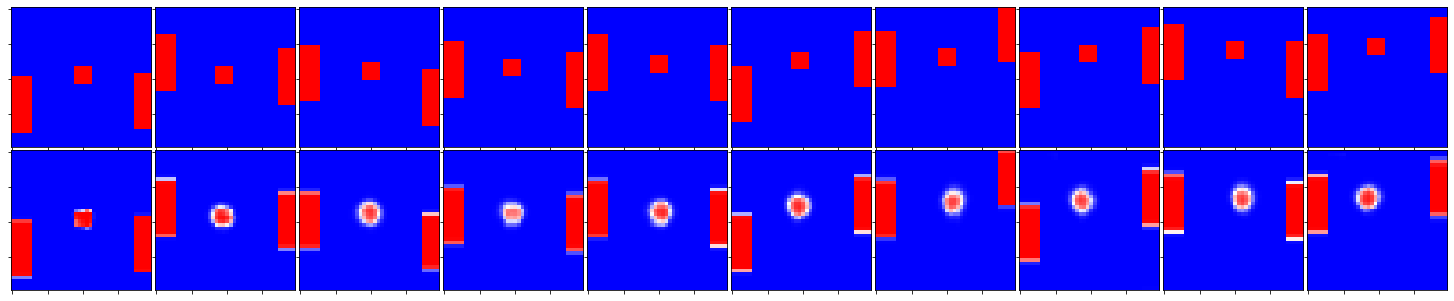

Epoch 1/2000
128/128 [==============================] - 92s 719ms/step - loss: 0.0578 - mse: 0.0160 - val_loss: 0.0419 - val_mse: 0.0126
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


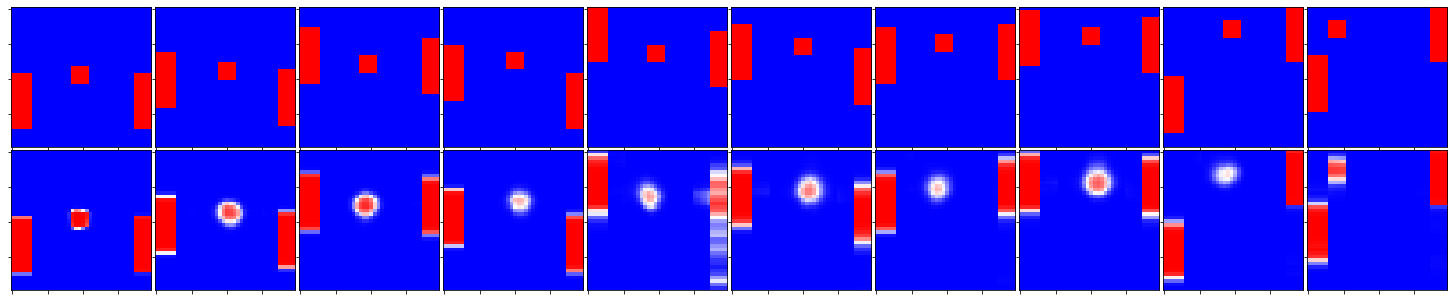

Epoch 2/2000
128/128 [==============================] - 50s 393ms/step - loss: 0.0427 - mse: 0.0127 - val_loss: 0.0419 - val_mse: 0.0126
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


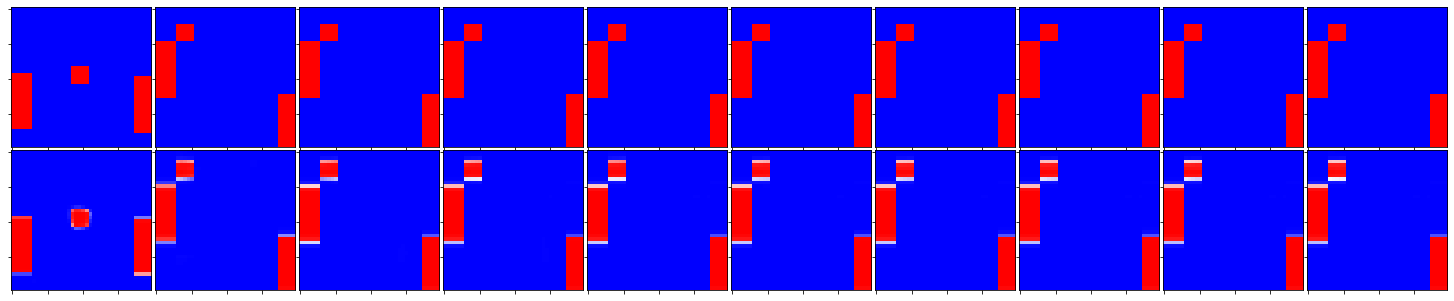

Epoch 3/2000
128/128 [==============================] - 51s 395ms/step - loss: 0.0410 - mse: 0.0122 - val_loss: 0.0390 - val_mse: 0.0115
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


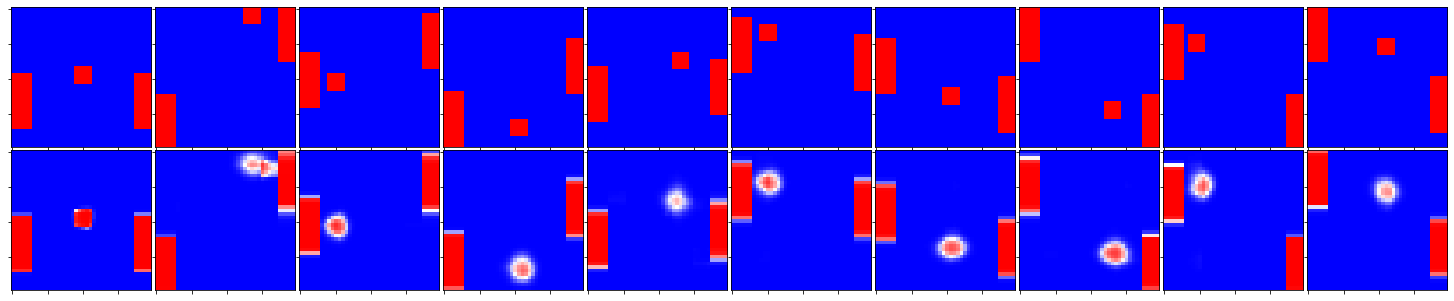

Epoch 4/2000
128/128 [==============================] - 50s 392ms/step - loss: 0.0398 - mse: 0.0118 - val_loss: 0.0398 - val_mse: 0.0120
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


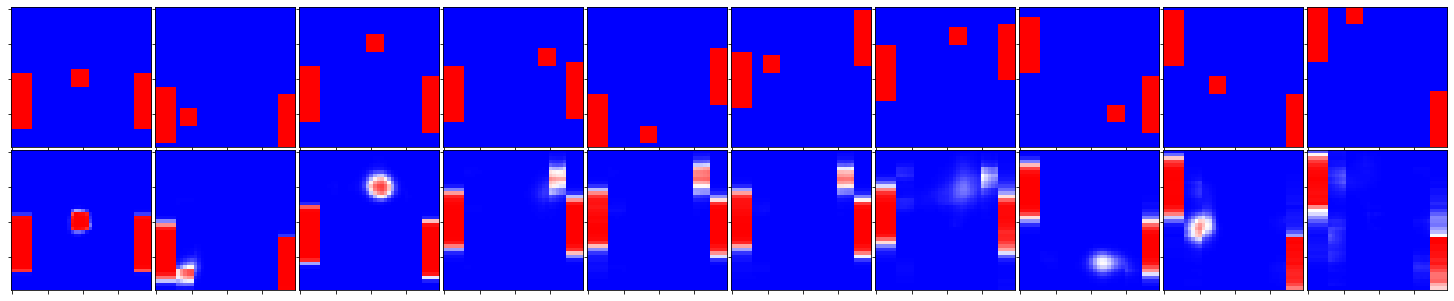

Epoch 5/2000
128/128 [==============================] - 51s 395ms/step - loss: 0.0422 - mse: 0.0125 - val_loss: 0.0481 - val_mse: 0.0142
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


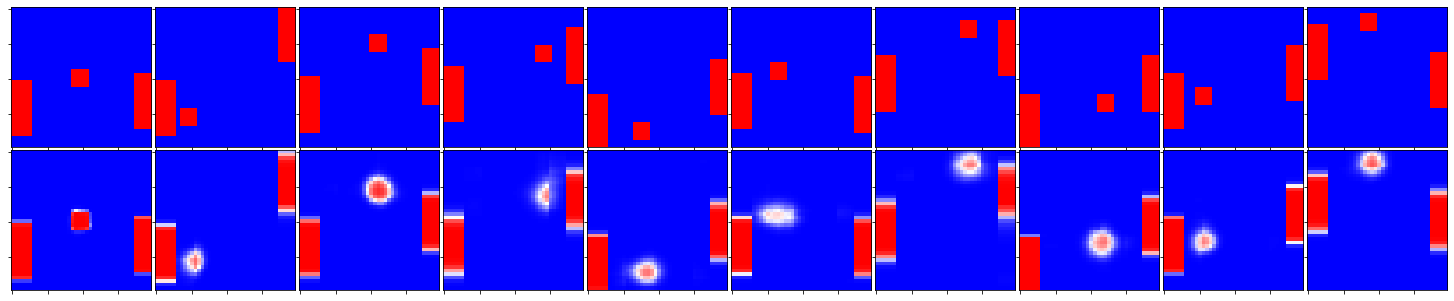

Epoch 6/2000
128/128 [==============================] - 50s 393ms/step - loss: 0.0397 - mse: 0.0118 - val_loss: 0.0336 - val_mse: 0.0100
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


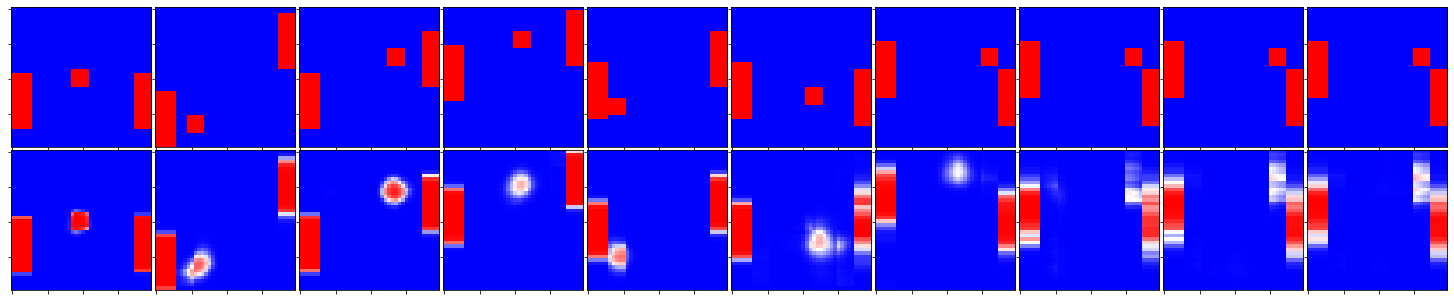

Epoch 7/2000
128/128 [==============================] - 50s 393ms/step - loss: 0.0388 - mse: 0.0116 - val_loss: 0.0322 - val_mse: 0.0097
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


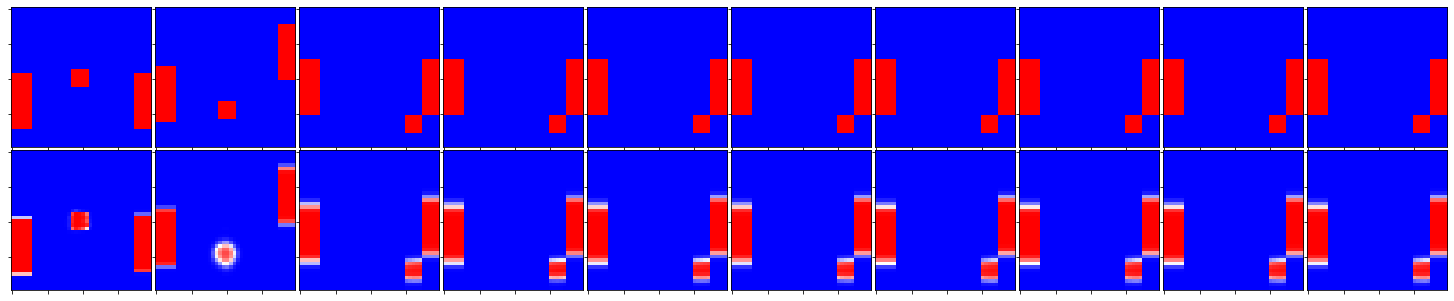

Epoch 8/2000
128/128 [==============================] - 50s 393ms/step - loss: 0.0375 - mse: 0.0112 - val_loss: 0.0392 - val_mse: 0.0117
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


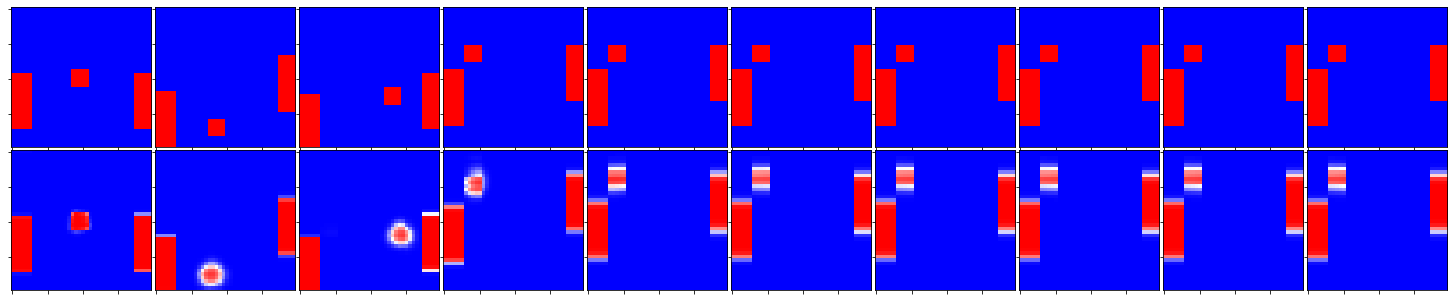

Epoch 9/2000
128/128 [==============================] - 50s 394ms/step - loss: 0.0371 - mse: 0.0111 - val_loss: 0.0420 - val_mse: 0.0126
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


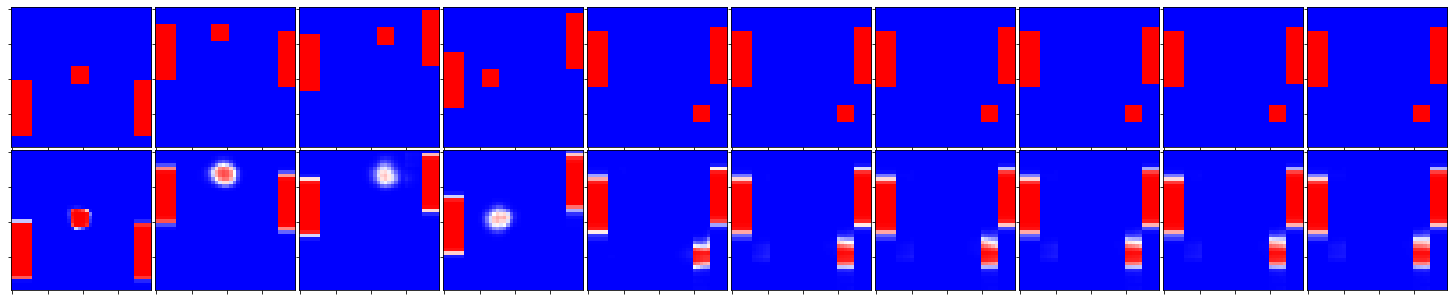

Epoch 10/2000
128/128 [==============================] - 50s 394ms/step - loss: 0.0395 - mse: 0.0118 - val_loss: 0.0312 - val_mse: 0.0094
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


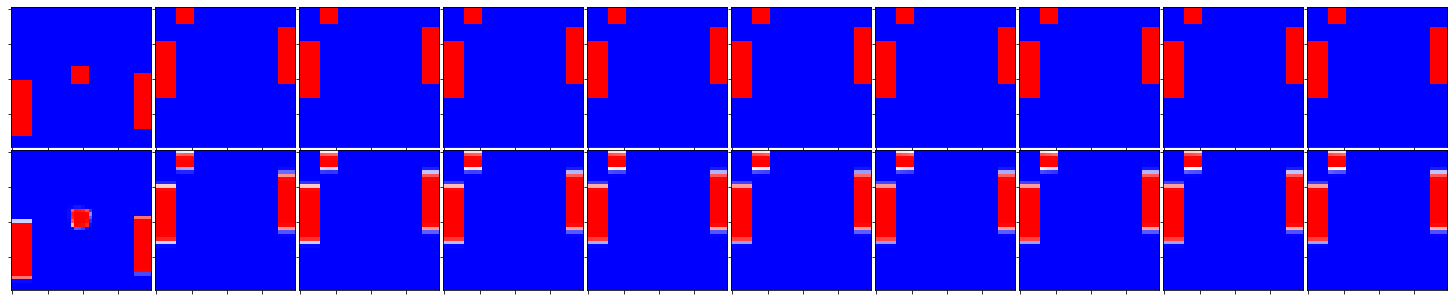

Epoch 11/2000
128/128 [==============================] - 51s 395ms/step - loss: 0.0343 - mse: 0.0102 - val_loss: 0.0374 - val_mse: 0.0112
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


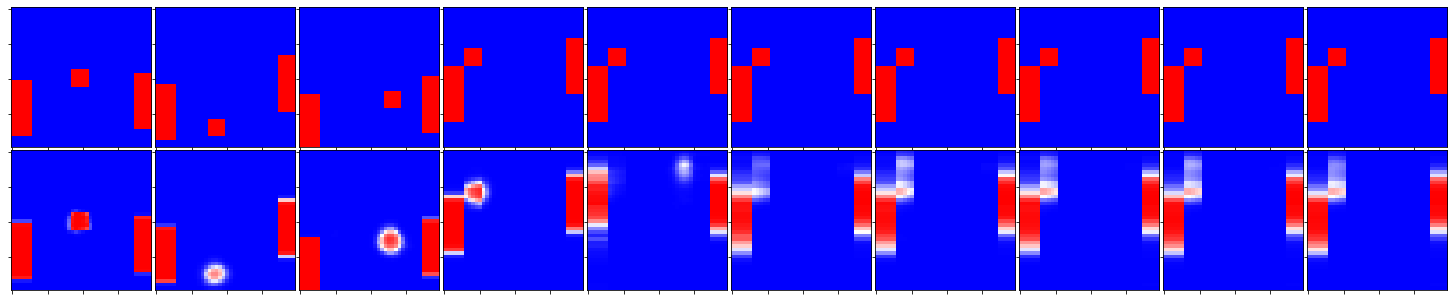

Epoch 12/2000
128/128 [==============================] - 50s 392ms/step - loss: 0.0393 - mse: 0.0117 - val_loss: 0.0339 - val_mse: 0.0102
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


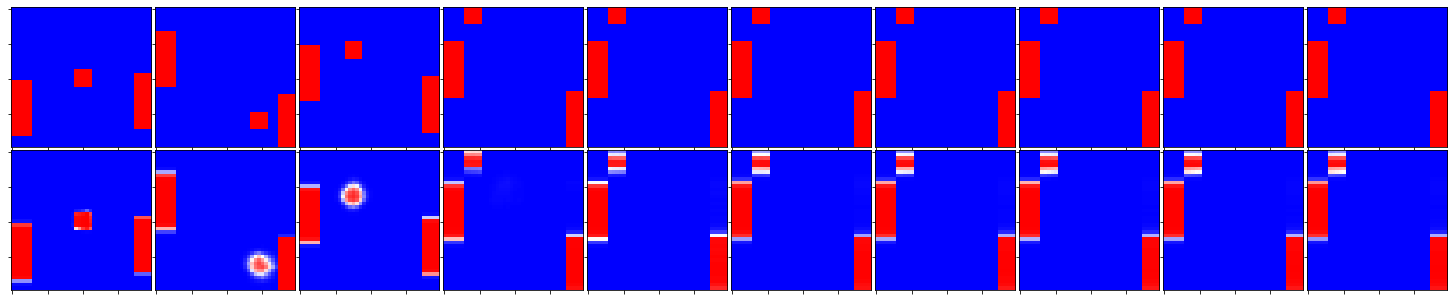

Epoch 13/2000
128/128 [==============================] - 50s 392ms/step - loss: 0.0370 - mse: 0.0110 - val_loss: 0.0408 - val_mse: 0.0121
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


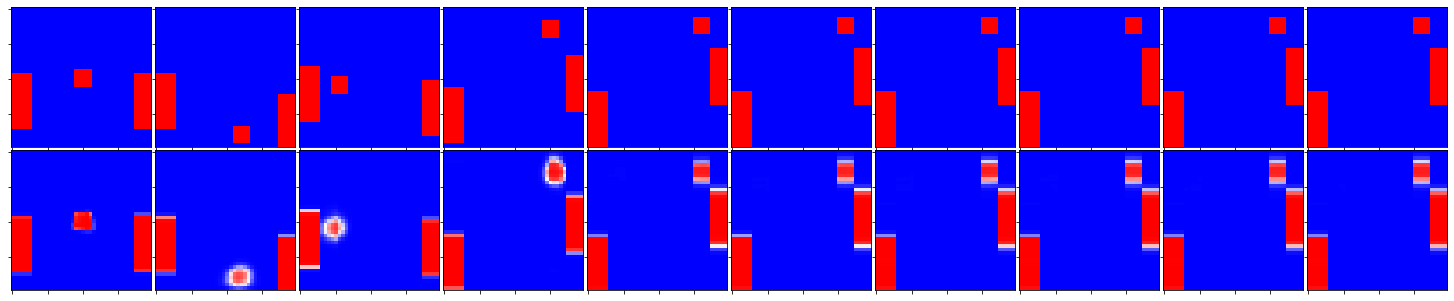

Epoch 14/2000
128/128 [==============================] - 50s 393ms/step - loss: 0.0363 - mse: 0.0108 - val_loss: 0.0388 - val_mse: 0.0116
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


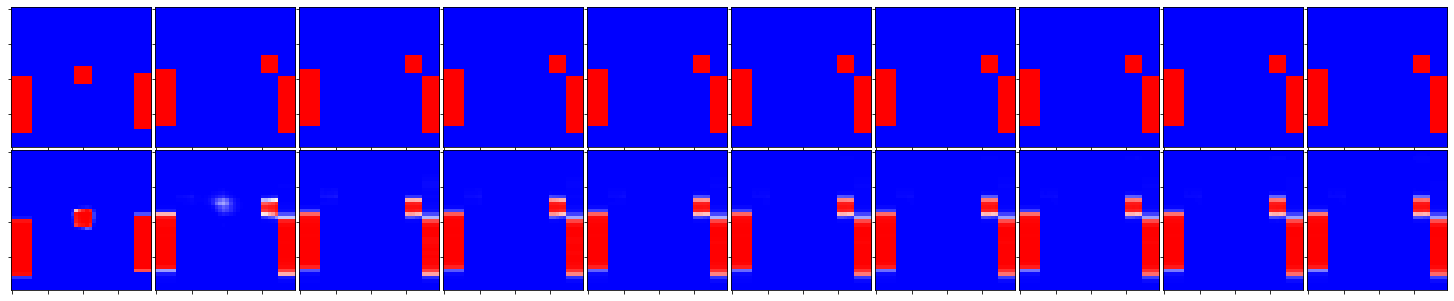

Epoch 15/2000
128/128 [==============================] - 50s 394ms/step - loss: 0.0354 - mse: 0.0106 - val_loss: 0.0335 - val_mse: 0.0101
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


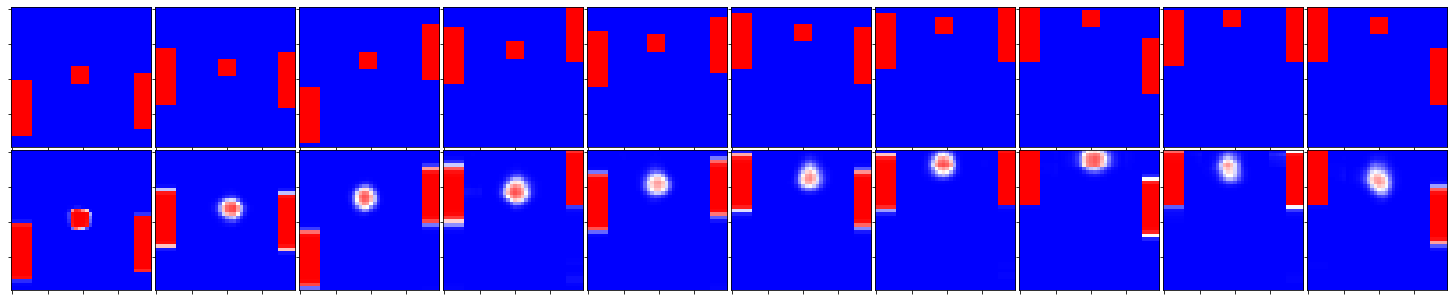

Epoch 16/2000
128/128 [==============================] - 50s 392ms/step - loss: 0.0366 - mse: 0.0109 - val_loss: 0.0341 - val_mse: 0.0103
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


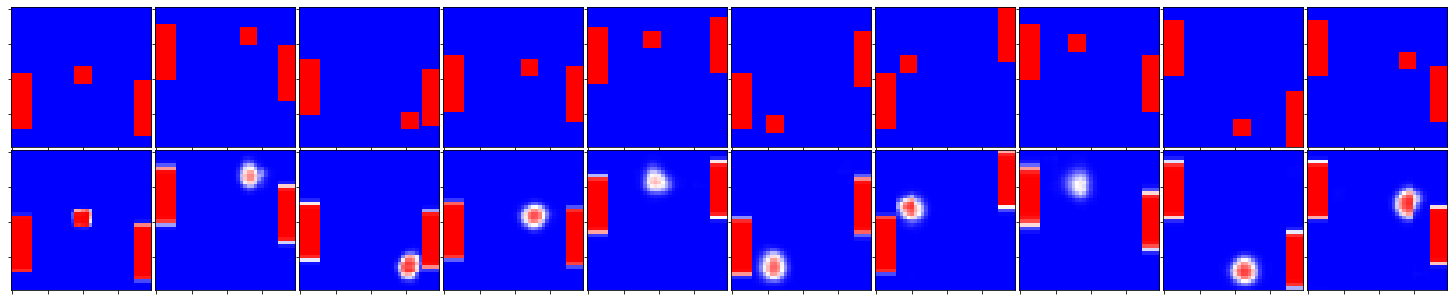

Epoch 17/2000
128/128 [==============================] - 50s 392ms/step - loss: 0.0341 - mse: 0.0102 - val_loss: 0.0300 - val_mse: 0.0089
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


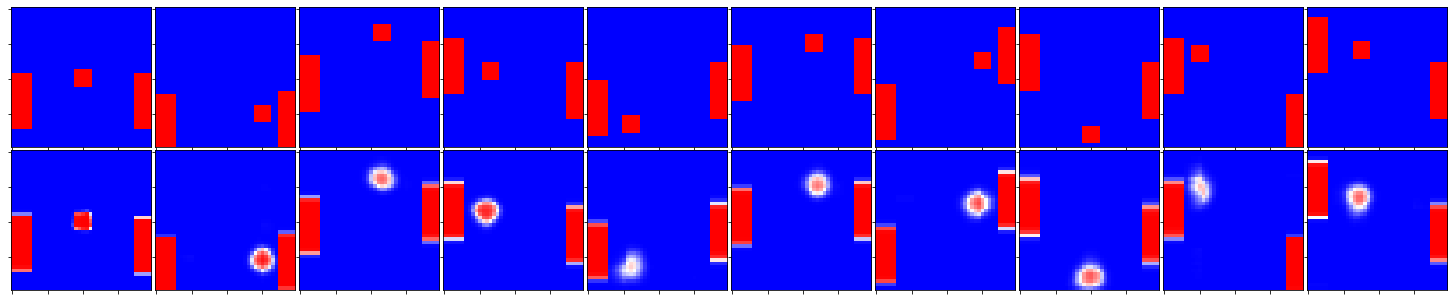

Epoch 18/2000
128/128 [==============================] - 50s 391ms/step - loss: 0.0316 - mse: 0.0095 - val_loss: 0.0382 - val_mse: 0.0113
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


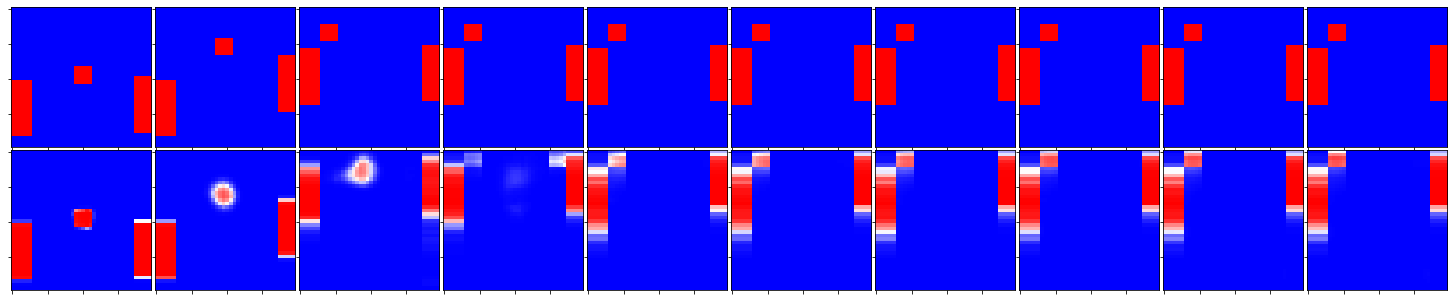

Epoch 19/2000
128/128 [==============================] - 50s 391ms/step - loss: 0.0342 - mse: 0.0102 - val_loss: 0.0409 - val_mse: 0.0120
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


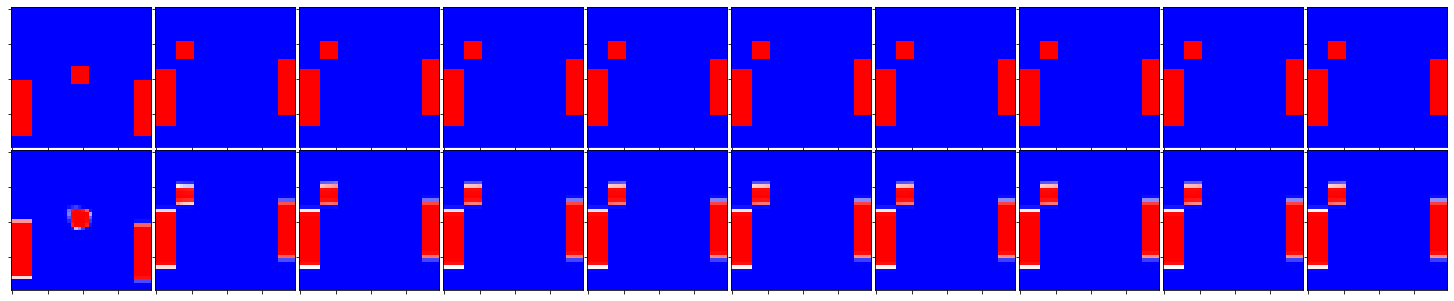

Epoch 20/2000
128/128 [==============================] - 50s 393ms/step - loss: 0.0377 - mse: 0.0112 - val_loss: 0.0362 - val_mse: 0.0107
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


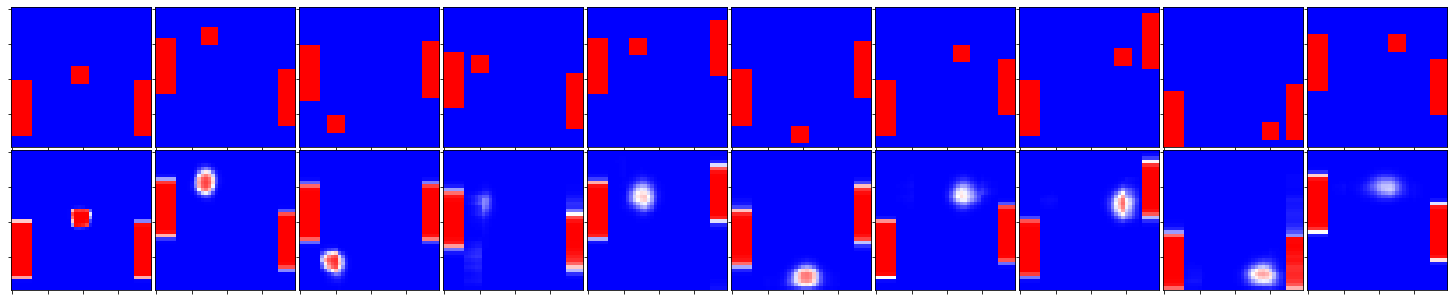

Epoch 21/2000
128/128 [==============================] - 50s 393ms/step - loss: 0.0344 - mse: 0.0103 - val_loss: 0.0413 - val_mse: 0.0123
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


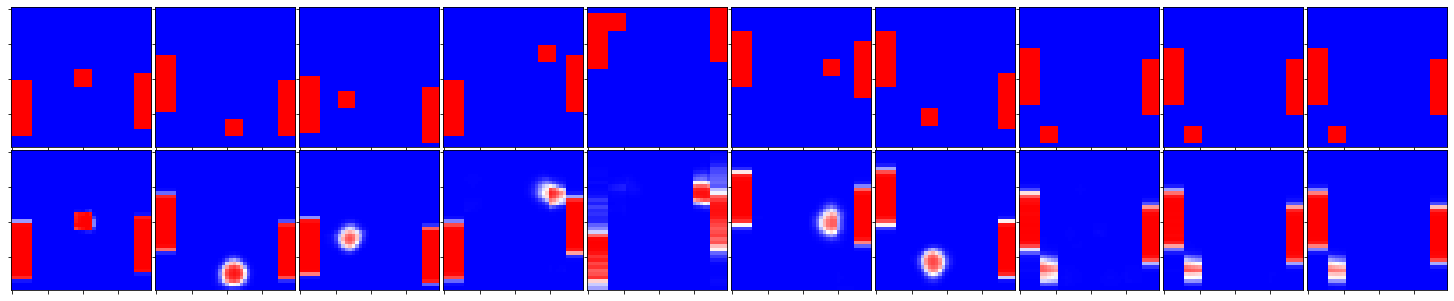

Epoch 22/2000
128/128 [==============================] - 50s 394ms/step - loss: 0.0336 - mse: 0.0101 - val_loss: 0.0314 - val_mse: 0.0095
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


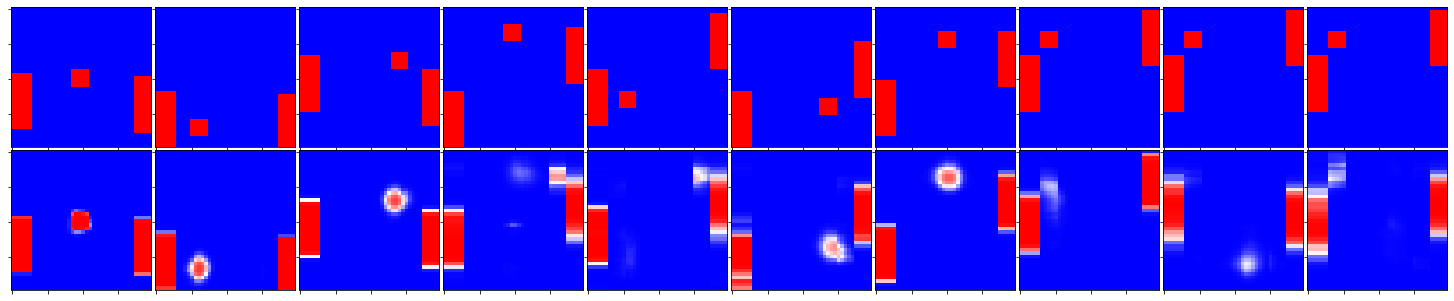

Epoch 23/2000
128/128 [==============================] - 50s 393ms/step - loss: 0.0364 - mse: 0.0108 - val_loss: 0.0375 - val_mse: 0.0108
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


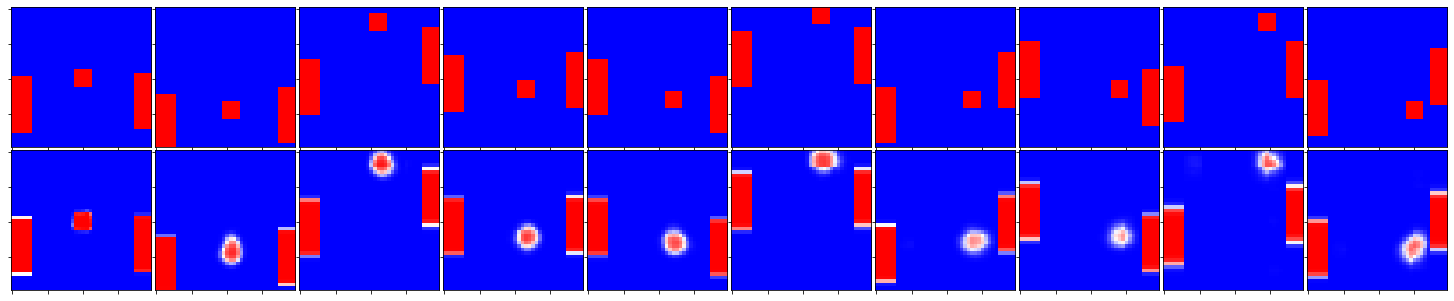

Epoch 24/2000
128/128 [==============================] - 50s 393ms/step - loss: 0.0355 - mse: 0.0106 - val_loss: 0.0294 - val_mse: 0.0088
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


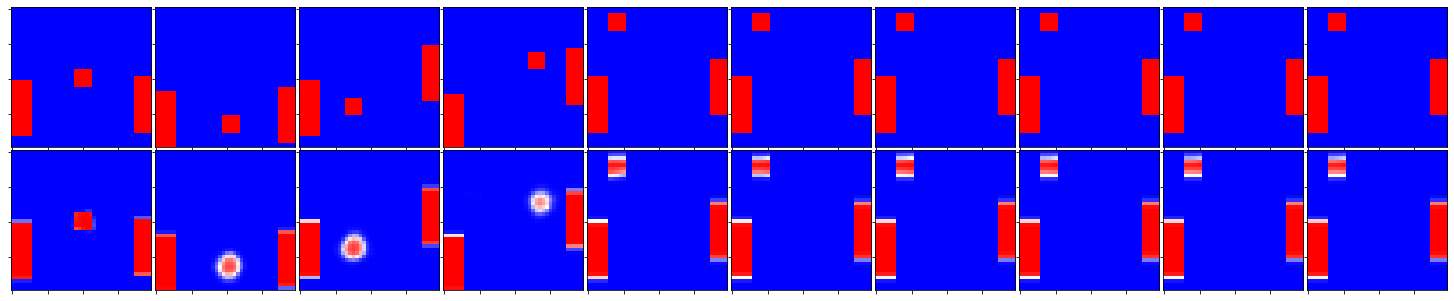

Epoch 25/2000
128/128 [==============================] - 50s 390ms/step - loss: 0.0312 - mse: 0.0094 - val_loss: 0.0311 - val_mse: 0.0093
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


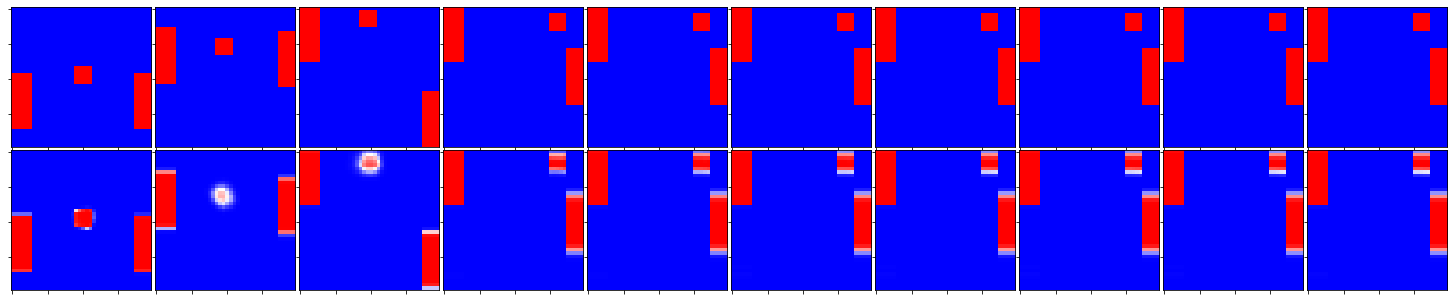

Epoch 26/2000
128/128 [==============================] - 50s 393ms/step - loss: 0.0355 - mse: 0.0106 - val_loss: 0.0350 - val_mse: 0.0104
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


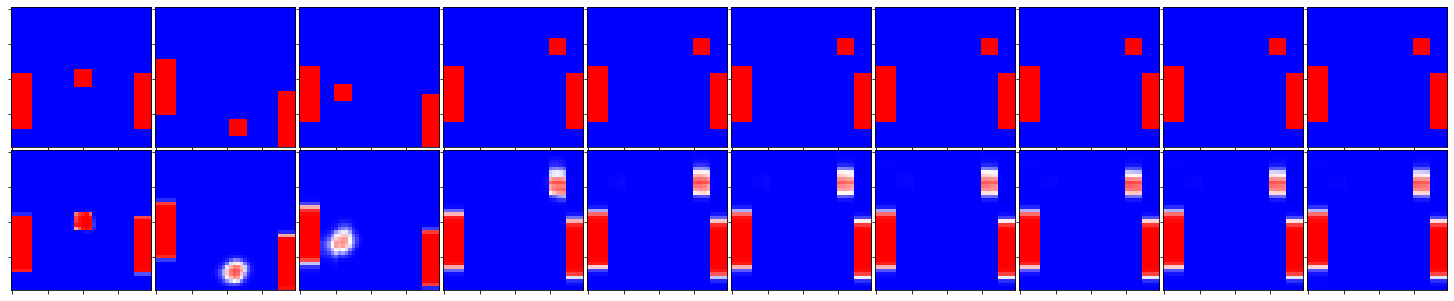

Epoch 27/2000
128/128 [==============================] - 50s 394ms/step - loss: 0.0383 - mse: 0.0114 - val_loss: 0.0371 - val_mse: 0.0108
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


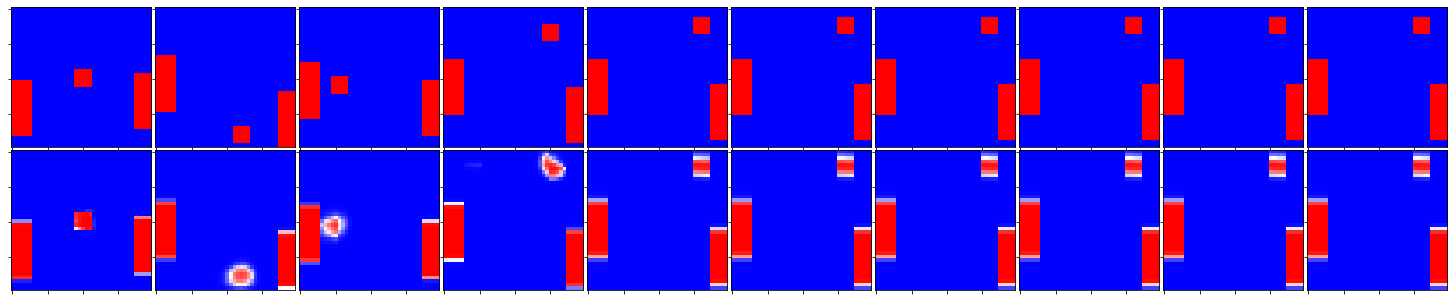

Epoch 28/2000
128/128 [==============================] - 50s 393ms/step - loss: 0.0344 - mse: 0.0103 - val_loss: 0.0379 - val_mse: 0.0111
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


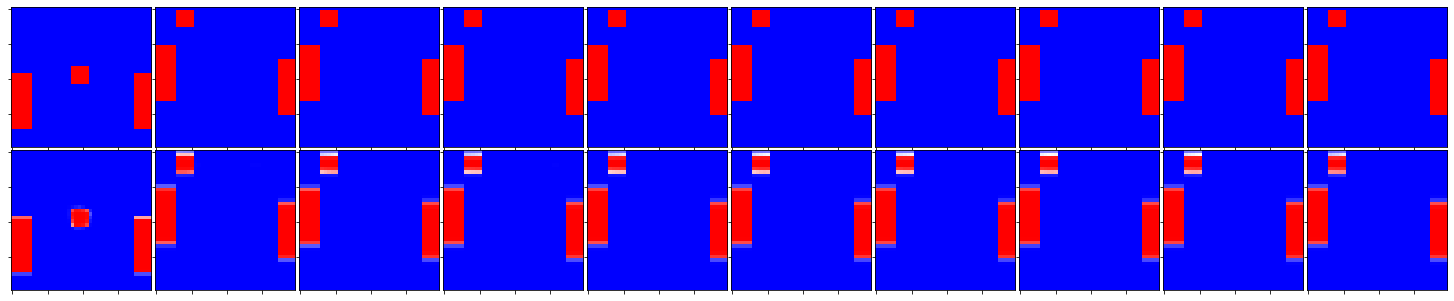

Epoch 29/2000
128/128 [==============================] - 50s 394ms/step - loss: 0.0377 - mse: 0.0112 - val_loss: 0.0406 - val_mse: 0.0121
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


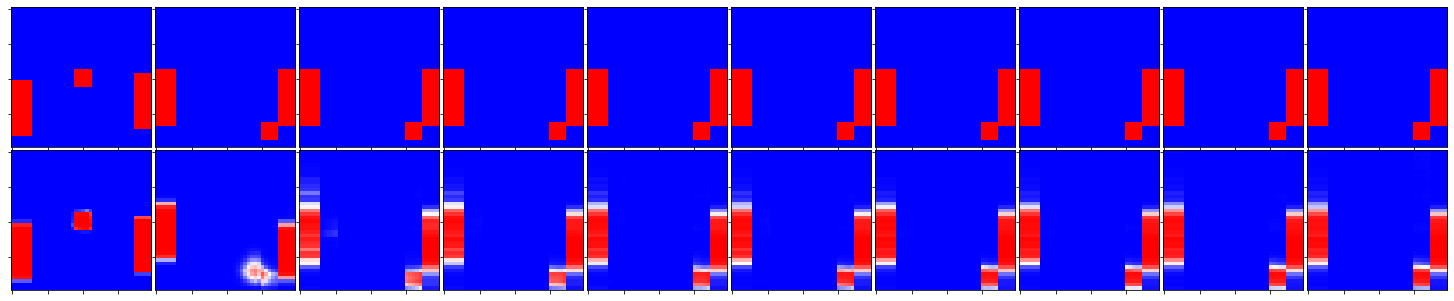

Epoch 30/2000
128/128 [==============================] - 50s 391ms/step - loss: 0.0448 - mse: 0.0132 - val_loss: 0.0426 - val_mse: 0.0126
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


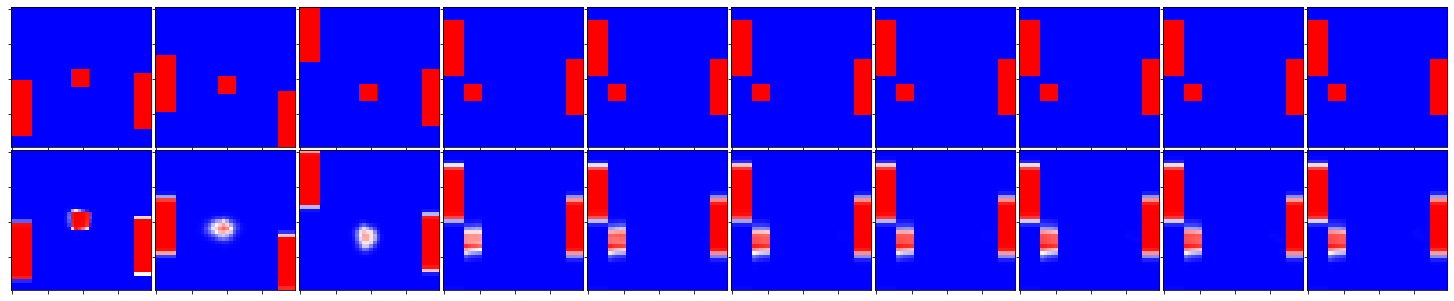

Epoch 31/2000
128/128 [==============================] - 51s 395ms/step - loss: 0.0345 - mse: 0.0103 - val_loss: 0.0326 - val_mse: 0.0098
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


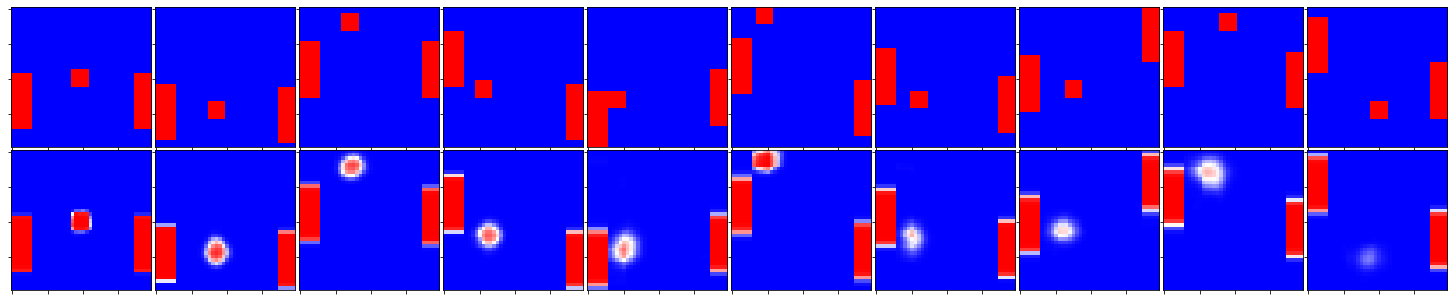

Epoch 32/2000
128/128 [==============================] - 51s 402ms/step - loss: 0.0290 - mse: 0.0087 - val_loss: 0.0349 - val_mse: 0.0106
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


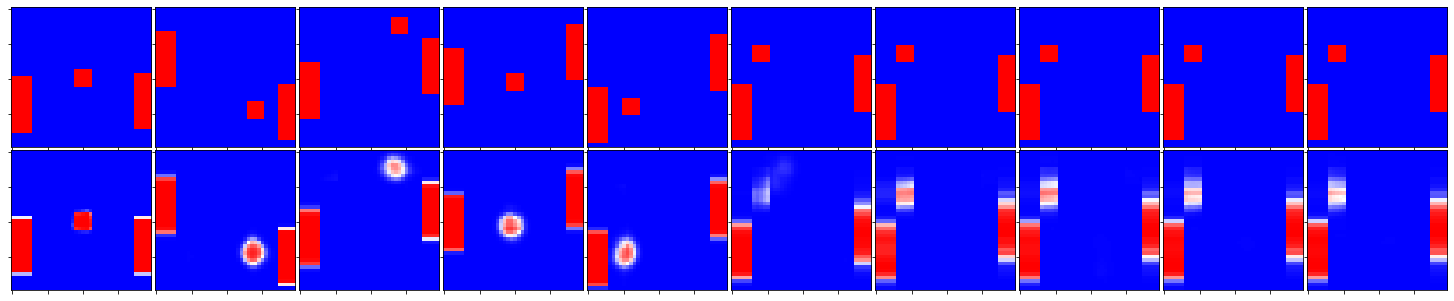

Epoch 33/2000
128/128 [==============================] - 51s 395ms/step - loss: 0.0300 - mse: 0.0090 - val_loss: 0.0379 - val_mse: 0.0110
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


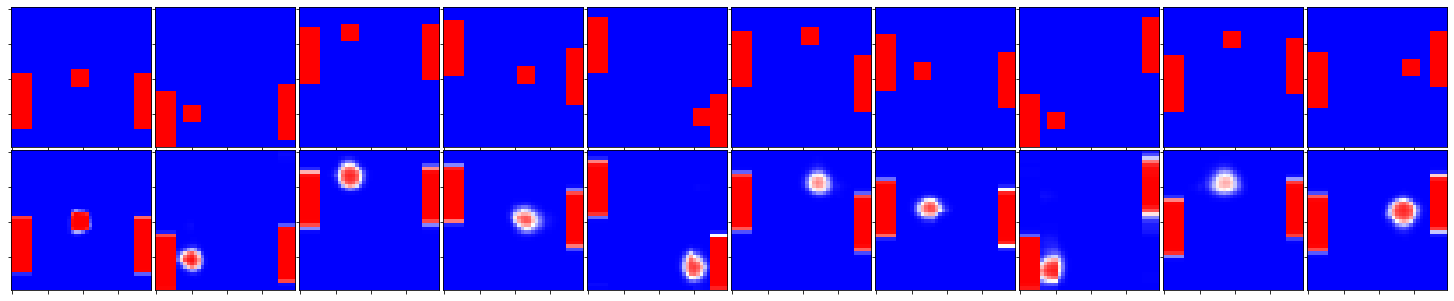

Epoch 34/2000
128/128 [==============================] - 51s 395ms/step - loss: 0.0338 - mse: 0.0101 - val_loss: 0.0296 - val_mse: 0.0089
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


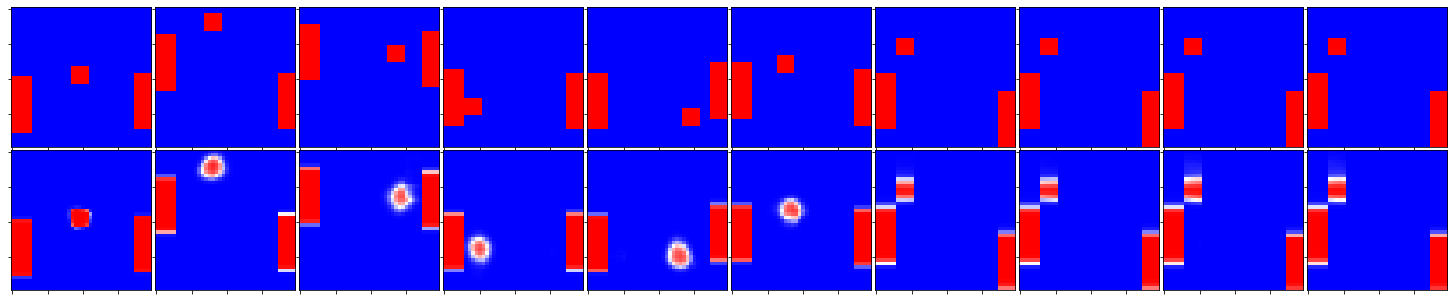

Epoch 35/2000
128/128 [==============================] - 49s 386ms/step - loss: 0.0326 - mse: 0.0098 - val_loss: 0.0314 - val_mse: 0.0095
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


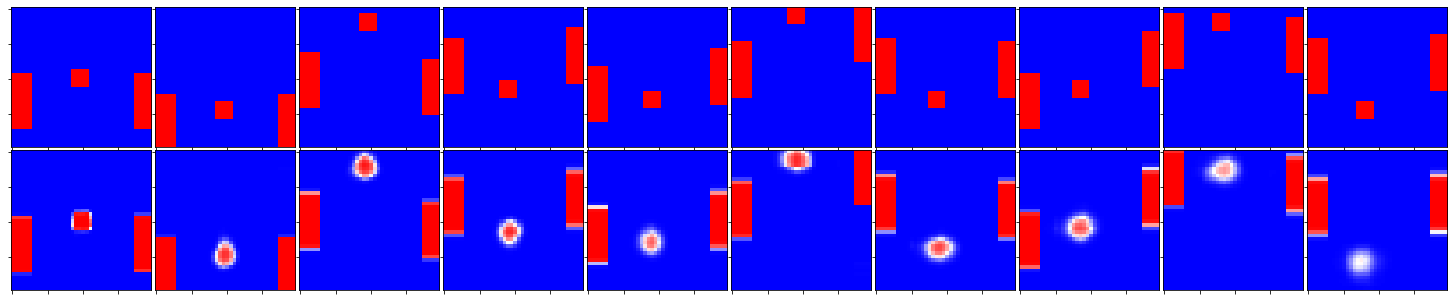

Epoch 36/2000
128/128 [==============================] - 51s 399ms/step - loss: 0.0334 - mse: 0.0098 - val_loss: 0.0406 - val_mse: 0.0122
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


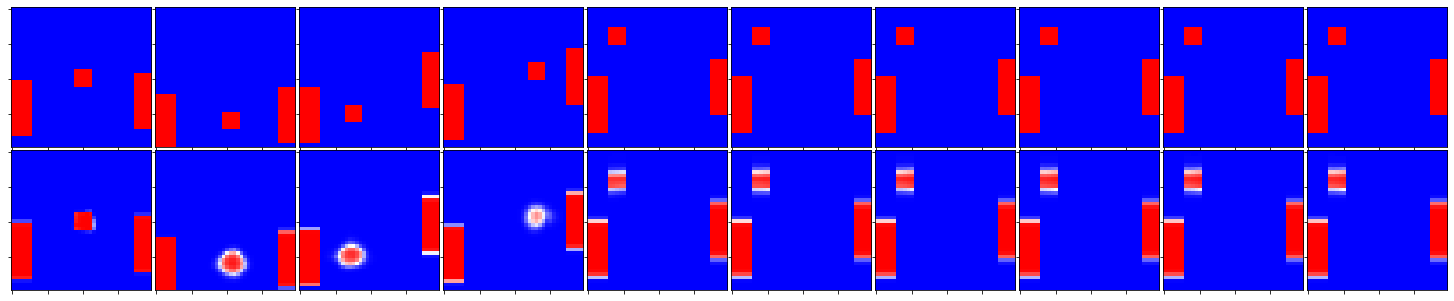

Epoch 37/2000
128/128 [==============================] - 50s 391ms/step - loss: 0.0355 - mse: 0.0106 - val_loss: 0.0351 - val_mse: 0.0106
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


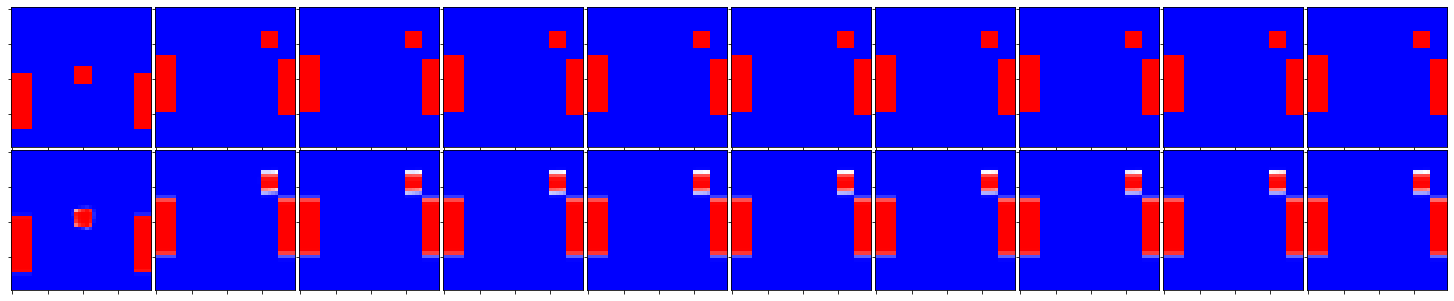

Epoch 38/2000
128/128 [==============================] - 51s 399ms/step - loss: 0.0385 - mse: 0.0114 - val_loss: 0.0435 - val_mse: 0.0128
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


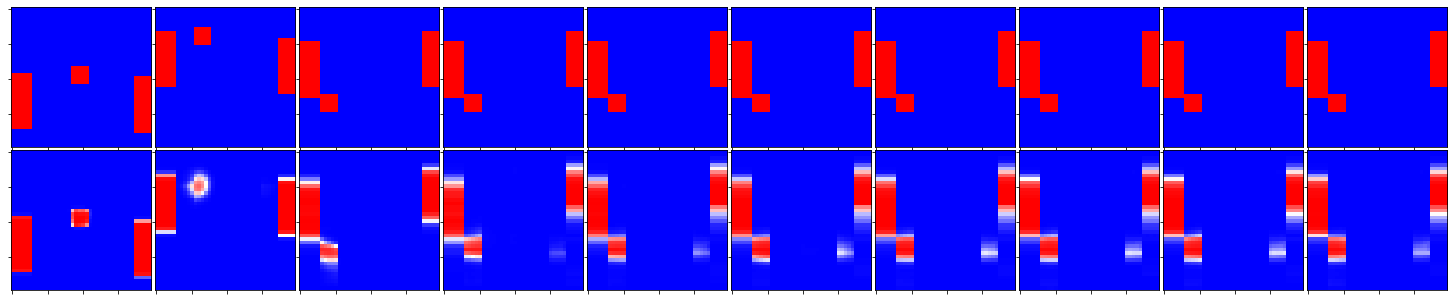

Epoch 39/2000
128/128 [==============================] - 52s 406ms/step - loss: 0.0357 - mse: 0.0106 - val_loss: 0.0308 - val_mse: 0.0092
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


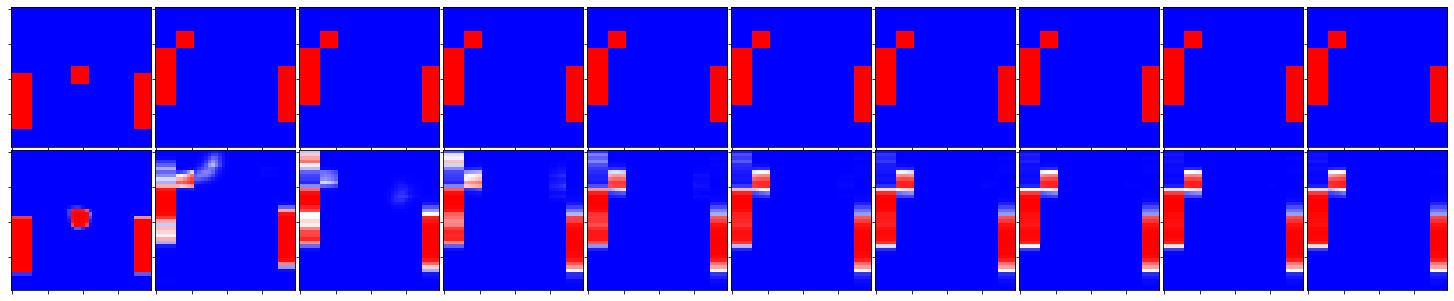

Epoch 40/2000
128/128 [==============================] - 51s 397ms/step - loss: 0.0308 - mse: 0.0092 - val_loss: 0.0310 - val_mse: 0.0094
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


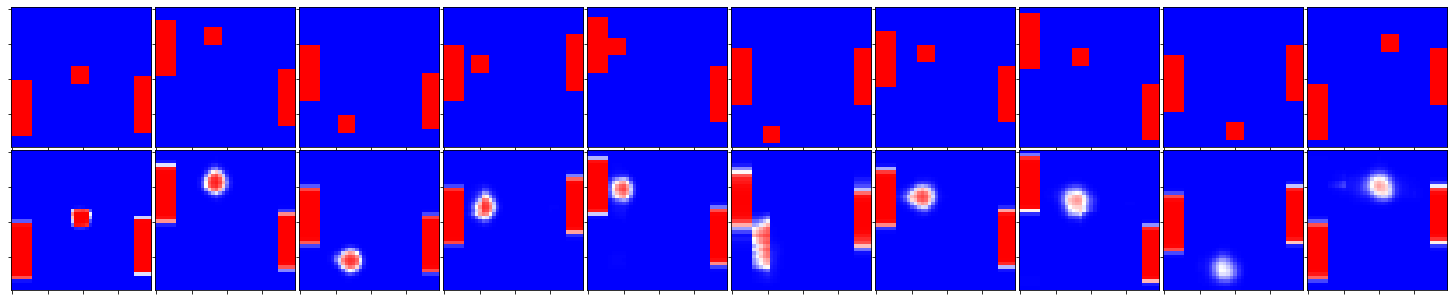

Epoch 41/2000
128/128 [==============================] - 50s 392ms/step - loss: 0.0294 - mse: 0.0088 - val_loss: 0.0328 - val_mse: 0.0099
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


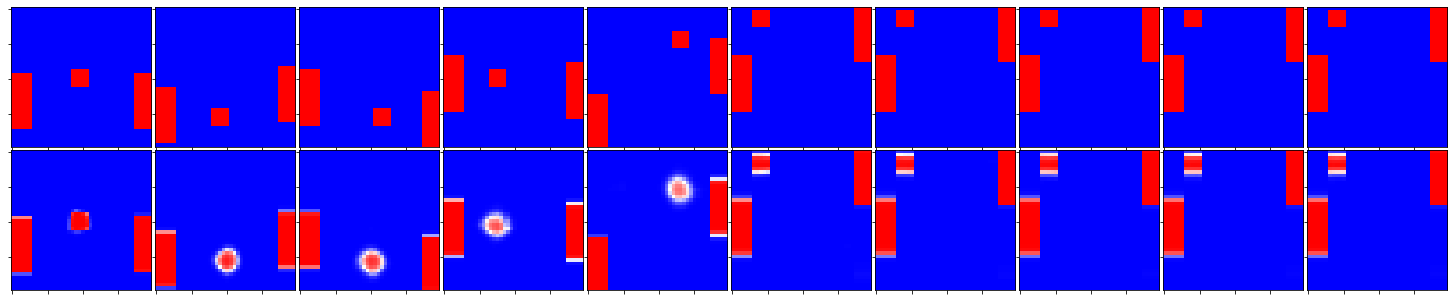

Epoch 42/2000
128/128 [==============================] - 50s 392ms/step - loss: 0.0365 - mse: 0.0109 - val_loss: 0.0360 - val_mse: 0.0109
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


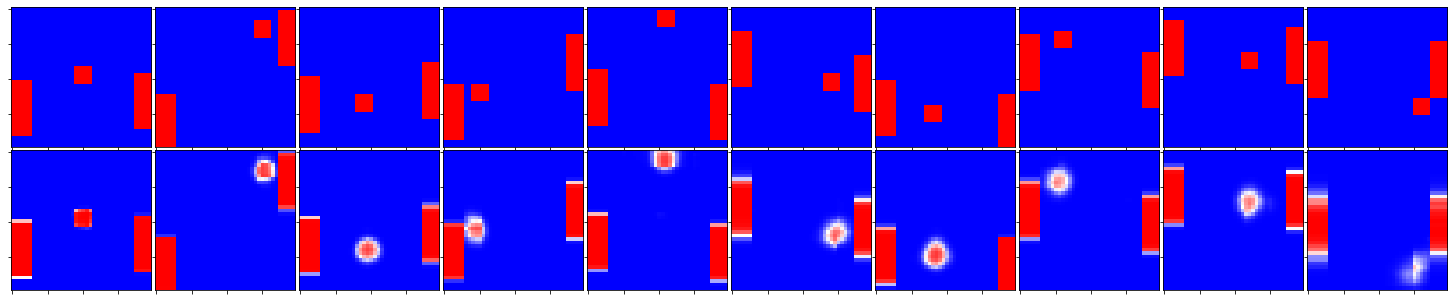

Epoch 43/2000
128/128 [==============================] - 50s 391ms/step - loss: 0.0323 - mse: 0.0097 - val_loss: 0.0332 - val_mse: 0.0101
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


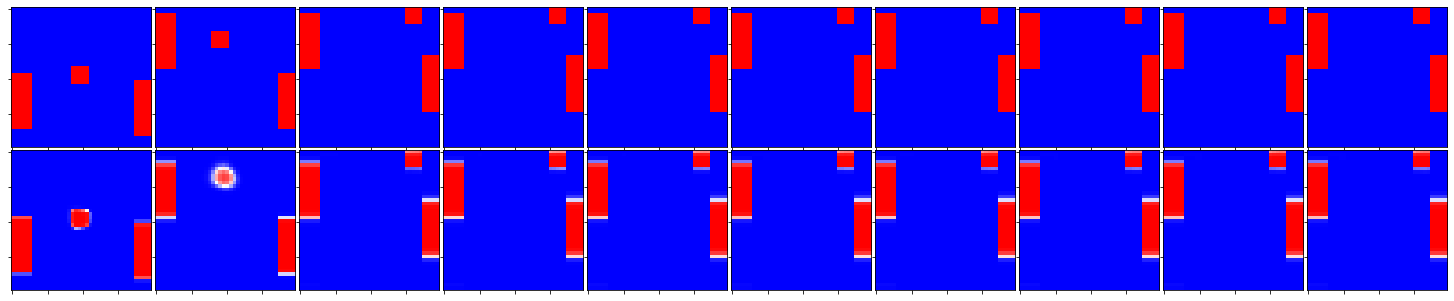

Epoch 44/2000
128/128 [==============================] - 51s 399ms/step - loss: 0.0337 - mse: 0.0100 - val_loss: 0.0432 - val_mse: 0.0128
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


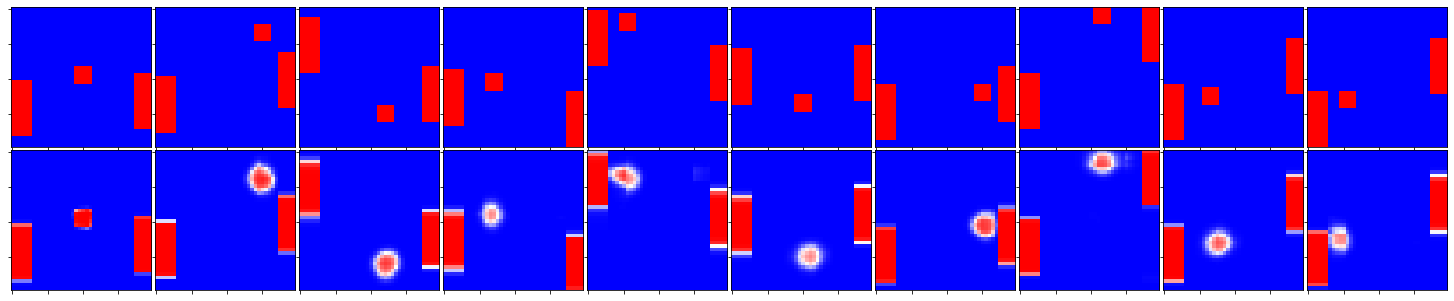

Epoch 45/2000
128/128 [==============================] - 50s 392ms/step - loss: 0.0353 - mse: 0.0105 - val_loss: 0.0320 - val_mse: 0.0097
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


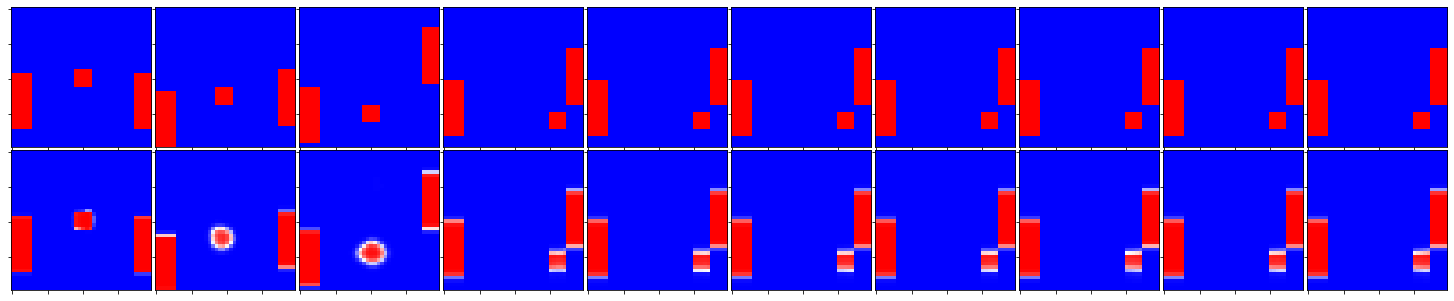

Epoch 46/2000
128/128 [==============================] - 50s 392ms/step - loss: 0.0343 - mse: 0.0102 - val_loss: 0.0307 - val_mse: 0.0093
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


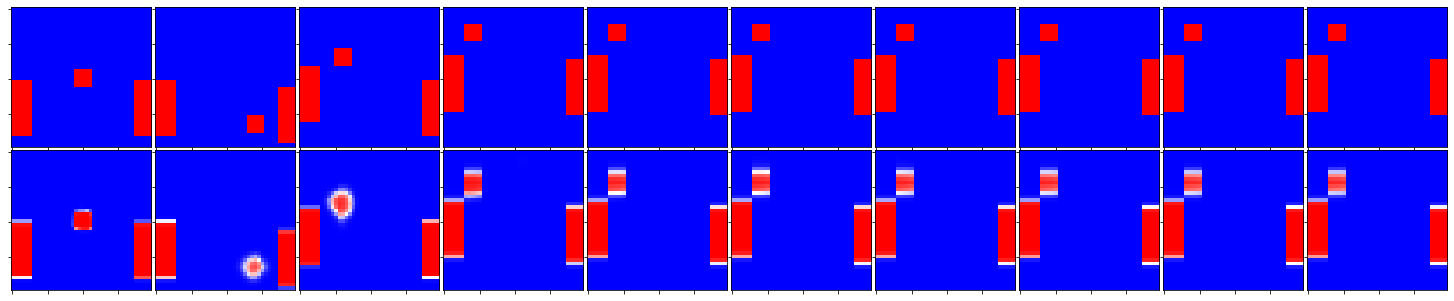

Epoch 47/2000
128/128 [==============================] - 50s 392ms/step - loss: 0.0262 - mse: 0.0078 - val_loss: 0.0243 - val_mse: 0.0072
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


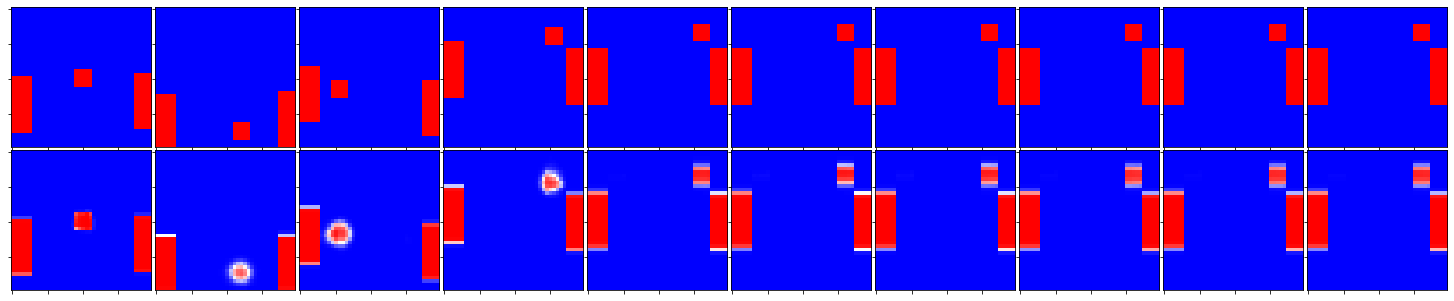

Epoch 48/2000
128/128 [==============================] - 50s 390ms/step - loss: 0.0266 - mse: 0.0079 - val_loss: 0.0446 - val_mse: 0.0134
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


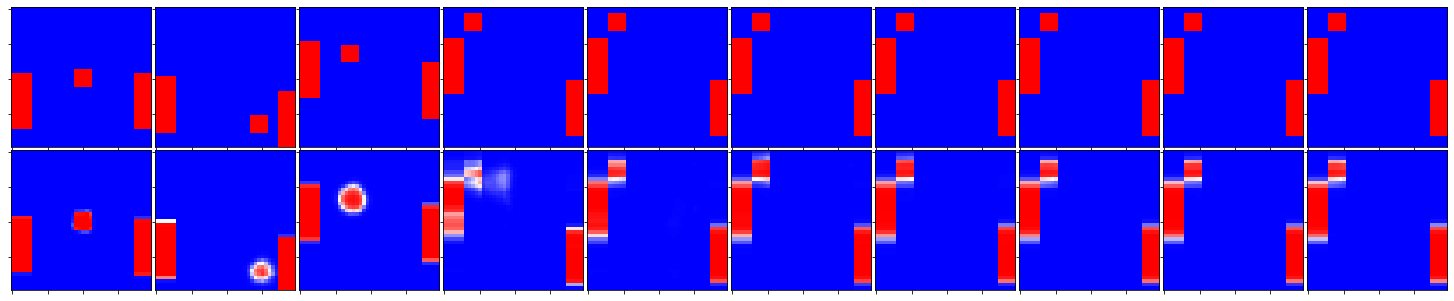

Epoch 49/2000
128/128 [==============================] - 51s 398ms/step - loss: 0.0403 - mse: 0.0119 - val_loss: 0.0372 - val_mse: 0.0112
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


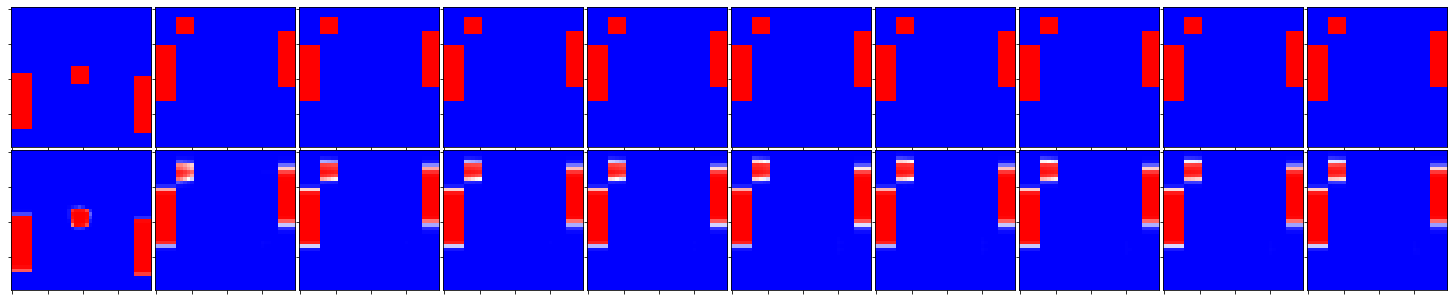

Epoch 50/2000
128/128 [==============================] - 51s 397ms/step - loss: 0.0311 - mse: 0.0093 - val_loss: 0.0400 - val_mse: 0.0120
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


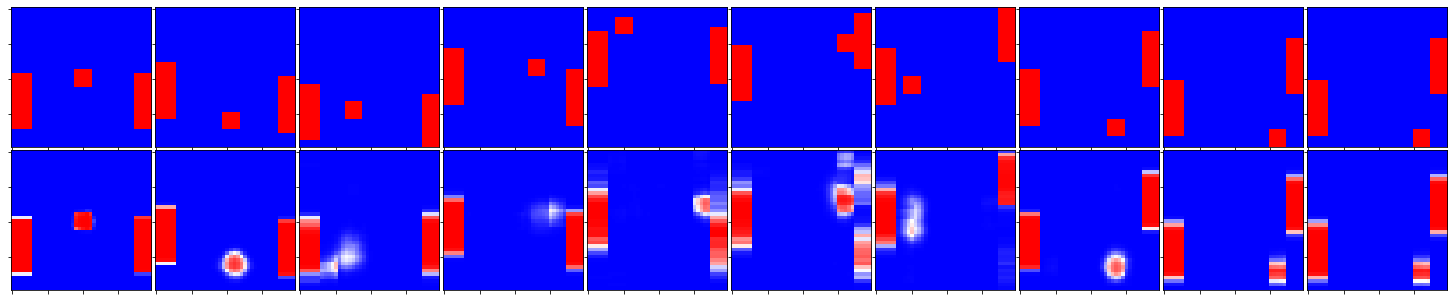

Epoch 51/2000
128/128 [==============================] - 50s 394ms/step - loss: 0.0334 - mse: 0.0099 - val_loss: 0.0308 - val_mse: 0.0092
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


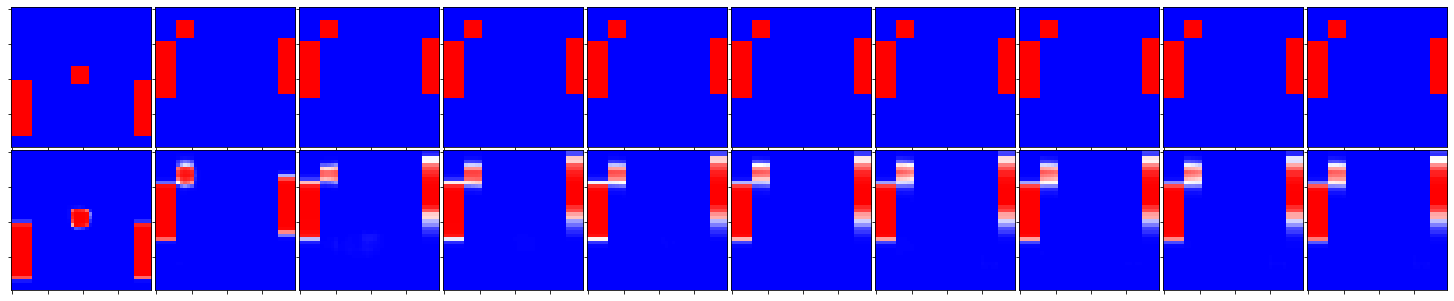

Epoch 52/2000
128/128 [==============================] - 51s 398ms/step - loss: 0.0331 - mse: 0.0098 - val_loss: 0.0408 - val_mse: 0.0122
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


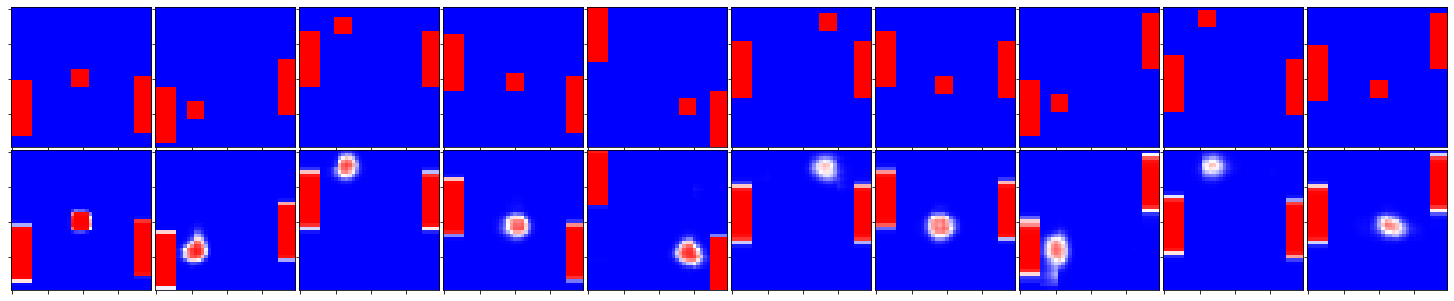

Epoch 53/2000
128/128 [==============================] - 52s 404ms/step - loss: 0.0324 - mse: 0.0097 - val_loss: 0.0299 - val_mse: 0.0088
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


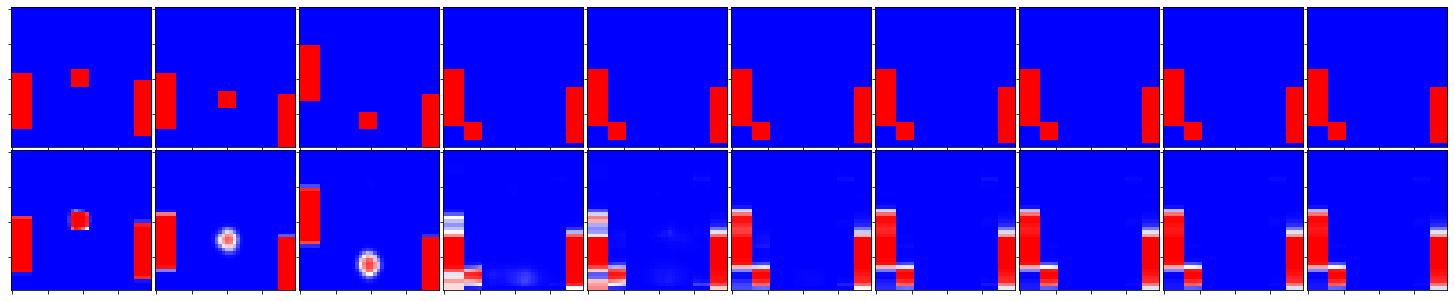

Epoch 54/2000
128/128 [==============================] - 52s 406ms/step - loss: 0.0270 - mse: 0.0081 - val_loss: 0.0325 - val_mse: 0.0097
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


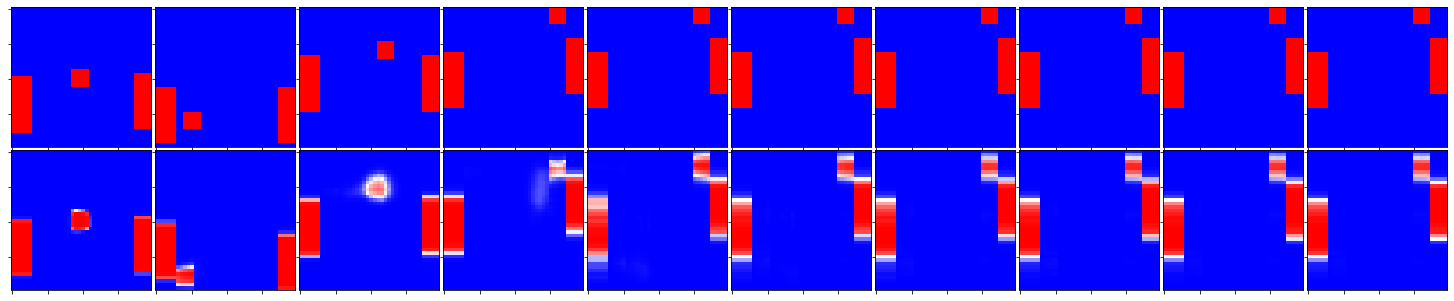

Epoch 55/2000
128/128 [==============================] - 52s 405ms/step - loss: 0.0332 - mse: 0.0099 - val_loss: 0.0349 - val_mse: 0.0102
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


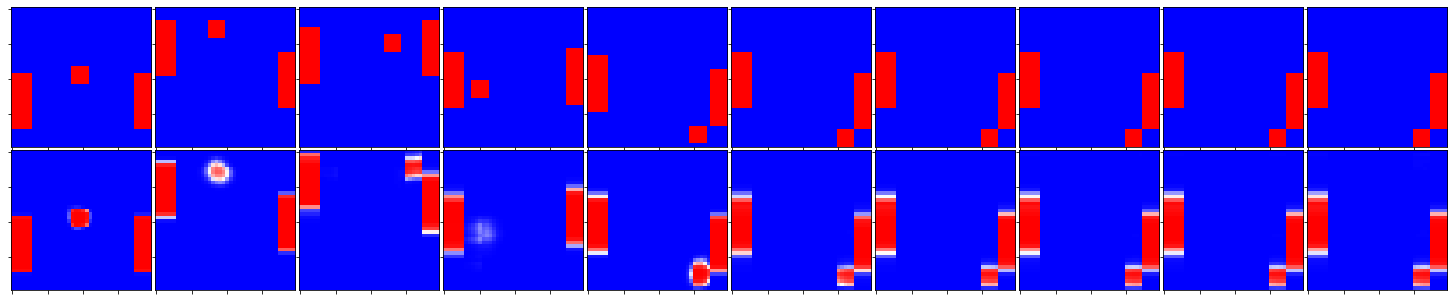

Epoch 56/2000
128/128 [==============================] - 50s 394ms/step - loss: 0.0317 - mse: 0.0095 - val_loss: 0.0368 - val_mse: 0.0105
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


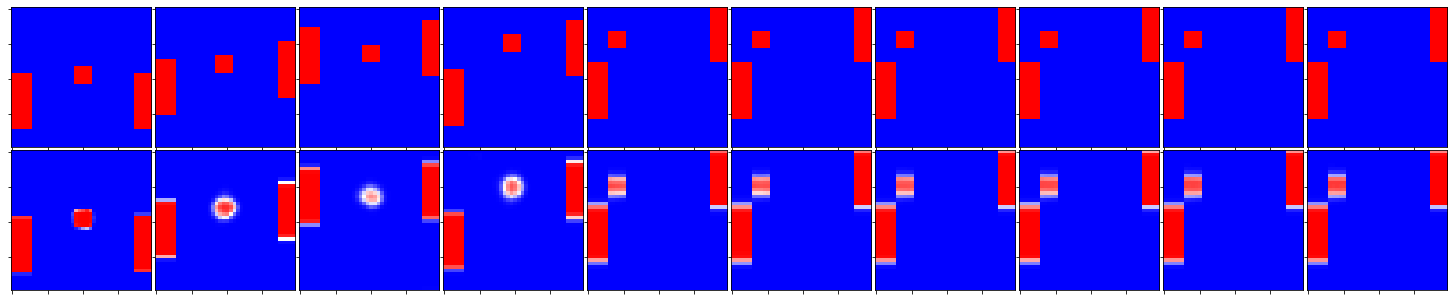

Epoch 57/2000
128/128 [==============================] - 50s 394ms/step - loss: 0.0284 - mse: 0.0085 - val_loss: 0.0252 - val_mse: 0.0076
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


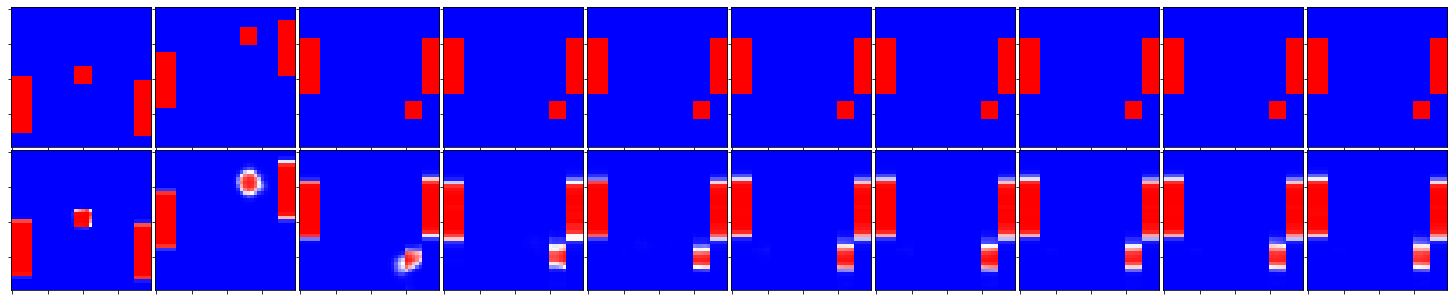

Epoch 58/2000
128/128 [==============================] - 51s 401ms/step - loss: 0.0267 - mse: 0.0080 - val_loss: 0.0377 - val_mse: 0.0108
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


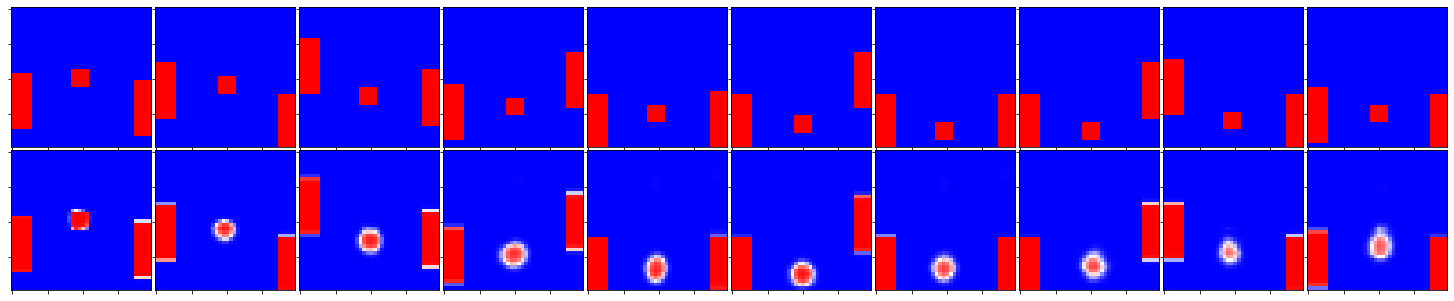

Epoch 59/2000
128/128 [==============================] - 51s 398ms/step - loss: 0.0371 - mse: 0.0110 - val_loss: 0.0415 - val_mse: 0.0125
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


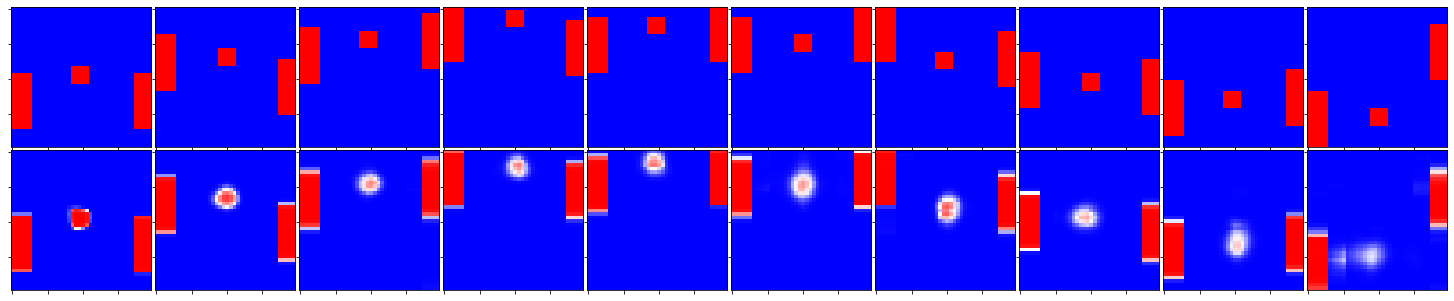

Epoch 60/2000
128/128 [==============================] - 51s 400ms/step - loss: 0.0286 - mse: 0.0085 - val_loss: 0.0253 - val_mse: 0.0076
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


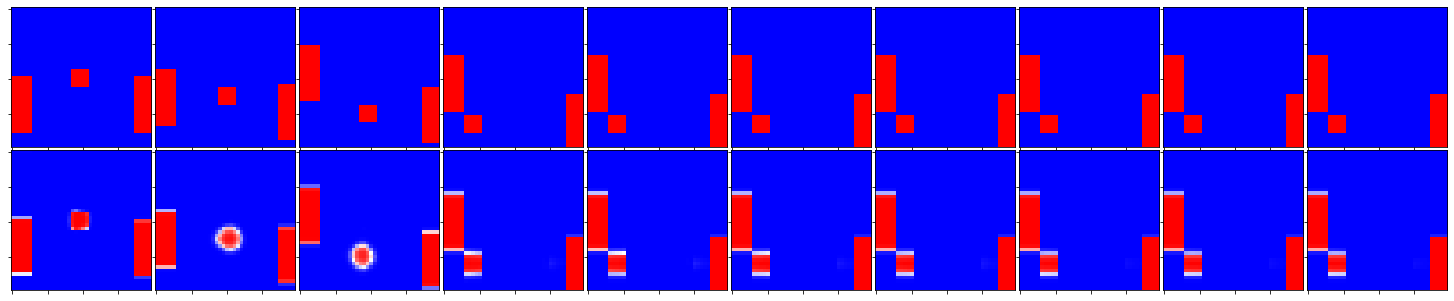

Epoch 61/2000
128/128 [==============================] - 51s 400ms/step - loss: 0.0299 - mse: 0.0088 - val_loss: 0.0380 - val_mse: 0.0116
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


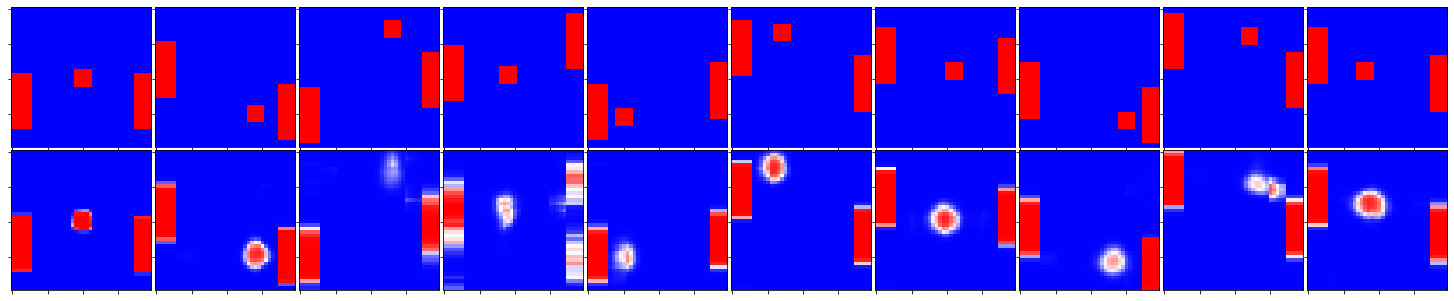

Epoch 62/2000
128/128 [==============================] - 51s 400ms/step - loss: 0.0354 - mse: 0.0105 - val_loss: 0.0339 - val_mse: 0.0103
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


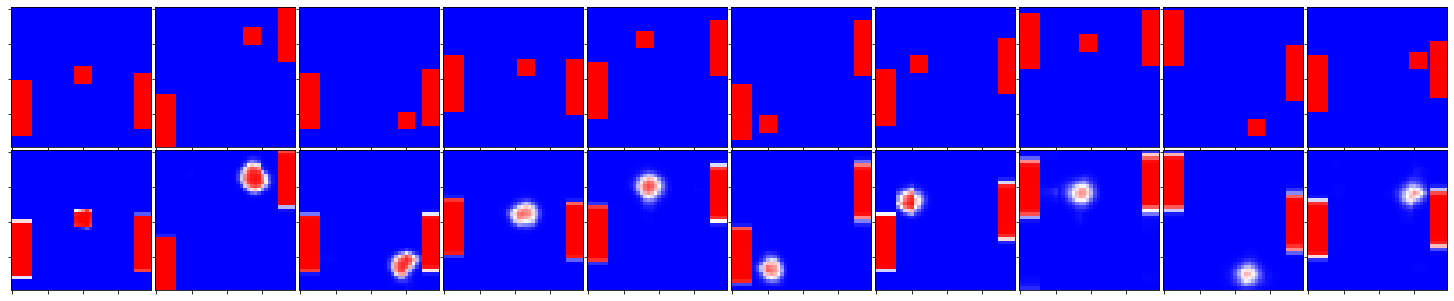

Epoch 63/2000
128/128 [==============================] - 51s 402ms/step - loss: 0.0320 - mse: 0.0095 - val_loss: 0.0374 - val_mse: 0.0111
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


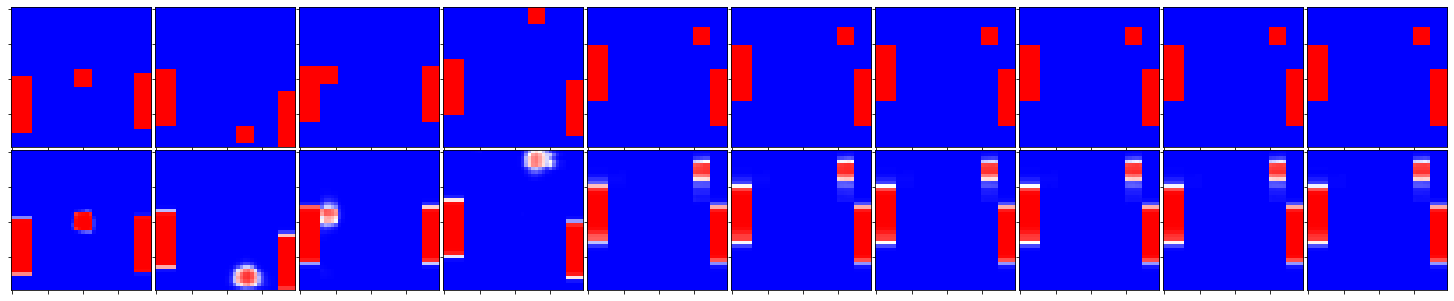

Epoch 64/2000
128/128 [==============================] - 51s 401ms/step - loss: 0.0322 - mse: 0.0096 - val_loss: 0.0418 - val_mse: 0.0117
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


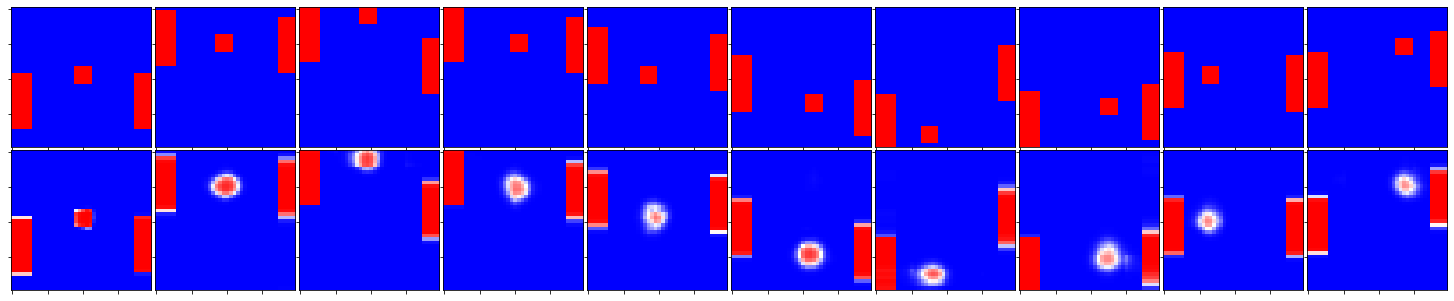

Epoch 65/2000
128/128 [==============================] - 51s 397ms/step - loss: 0.0279 - mse: 0.0084 - val_loss: 0.0292 - val_mse: 0.0086
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


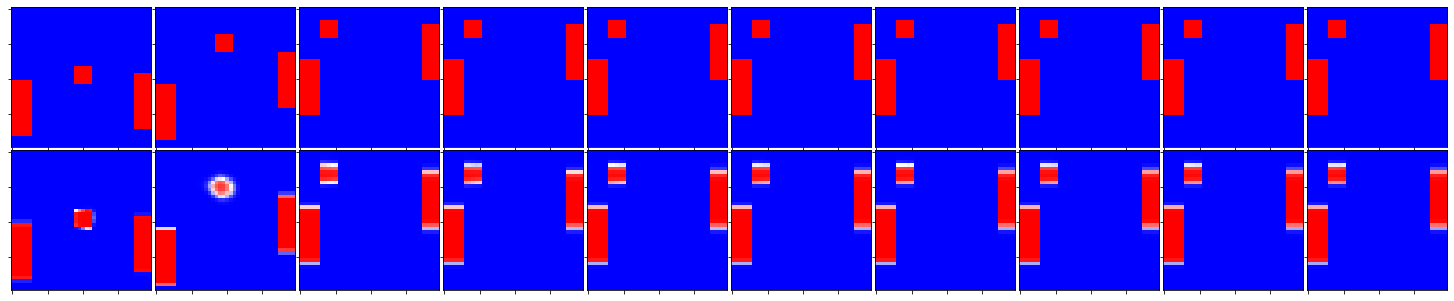

Epoch 66/2000
128/128 [==============================] - 51s 395ms/step - loss: 0.0269 - mse: 0.0080 - val_loss: 0.0361 - val_mse: 0.0108
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


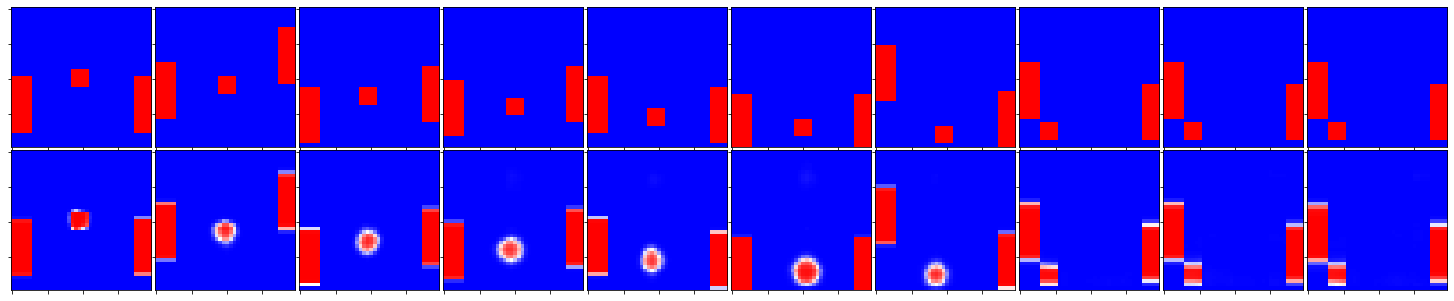

Epoch 67/2000
128/128 [==============================] - 50s 387ms/step - loss: 0.0395 - mse: 0.0116 - val_loss: 0.0299 - val_mse: 0.0088
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


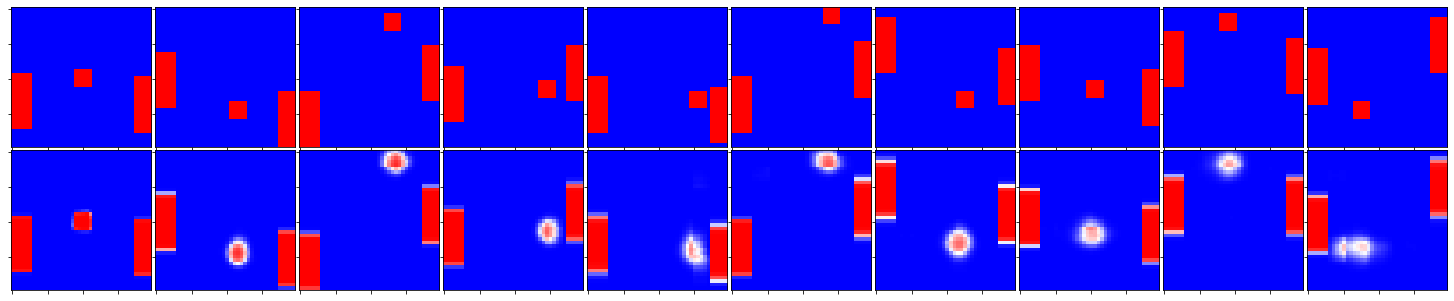

Epoch 68/2000
128/128 [==============================] - 50s 388ms/step - loss: 0.0290 - mse: 0.0087 - val_loss: 0.0260 - val_mse: 0.0079
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


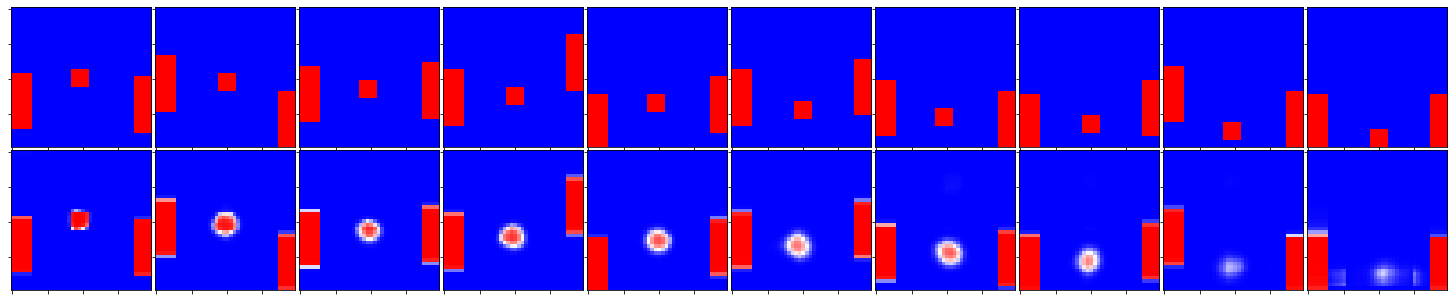

Epoch 69/2000
128/128 [==============================] - 50s 388ms/step - loss: 0.0256 - mse: 0.0076 - val_loss: 0.0270 - val_mse: 0.0080
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


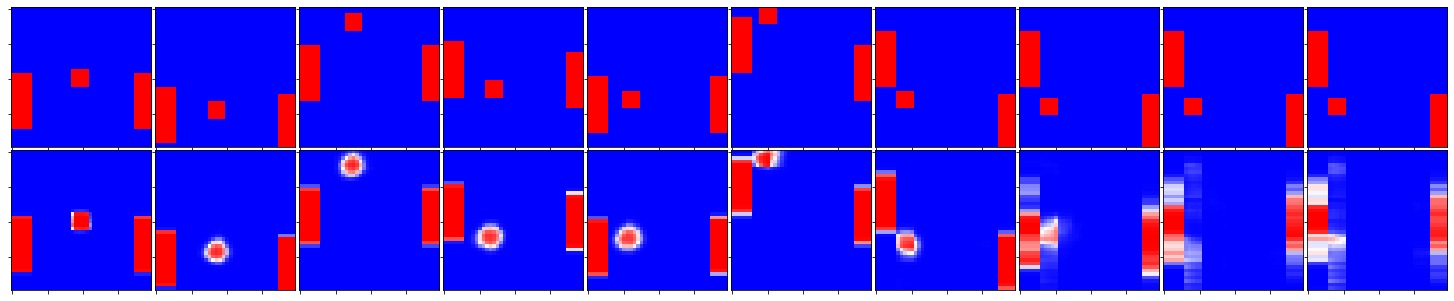

Epoch 70/2000
128/128 [==============================] - 49s 386ms/step - loss: 0.0371 - mse: 0.0109 - val_loss: 0.0496 - val_mse: 0.0145
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


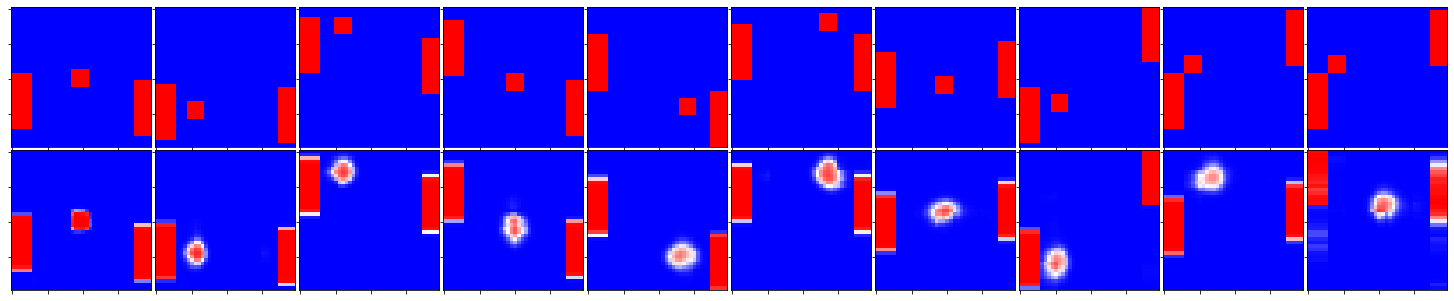

Epoch 71/2000
128/128 [==============================] - 50s 388ms/step - loss: 0.0368 - mse: 0.0110 - val_loss: 0.0382 - val_mse: 0.0117
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


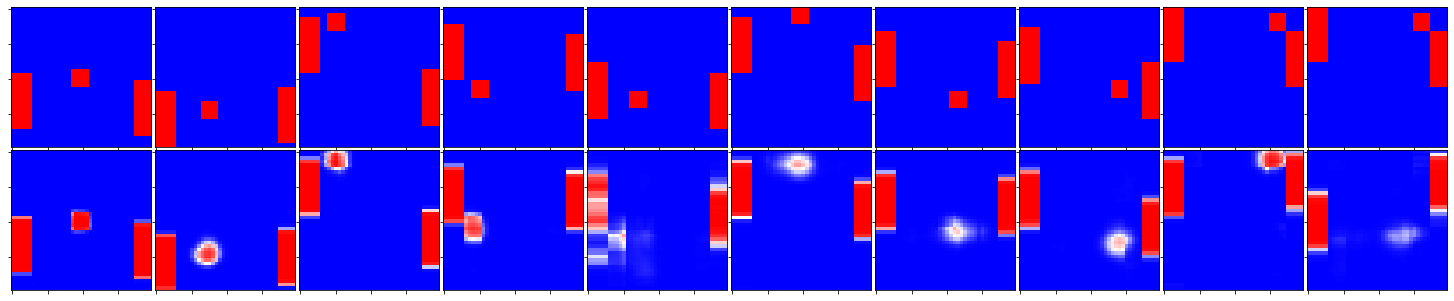

Epoch 72/2000
128/128 [==============================] - 49s 386ms/step - loss: 0.0296 - mse: 0.0089 - val_loss: 0.0289 - val_mse: 0.0087
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


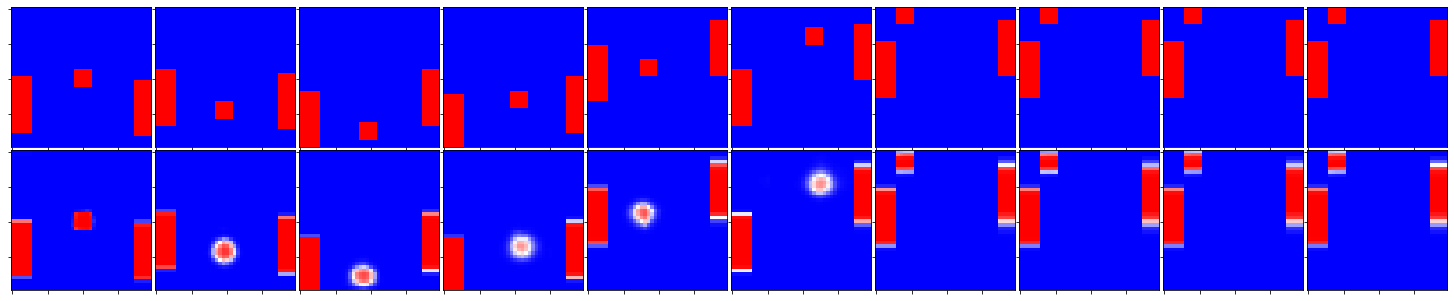

Epoch 73/2000
128/128 [==============================] - 50s 387ms/step - loss: 0.0271 - mse: 0.0081 - val_loss: 0.0289 - val_mse: 0.0088
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


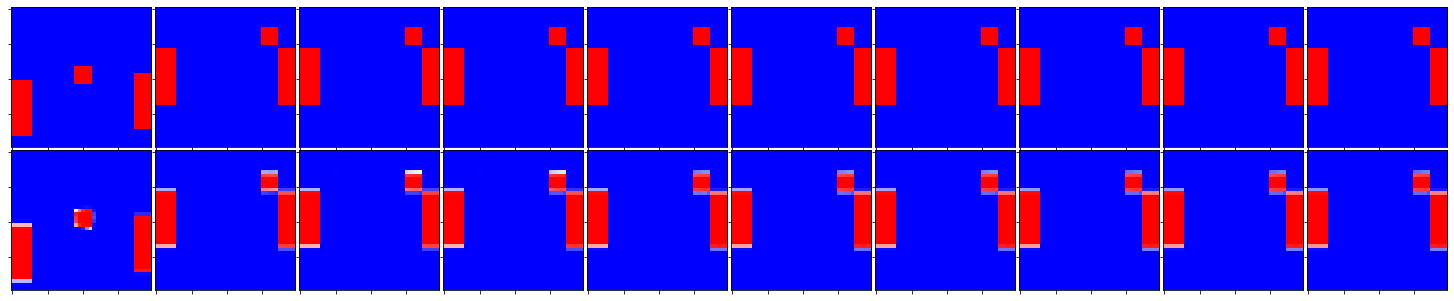

Epoch 74/2000
128/128 [==============================] - 50s 388ms/step - loss: 0.0269 - mse: 0.0080 - val_loss: 0.0302 - val_mse: 0.0091
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


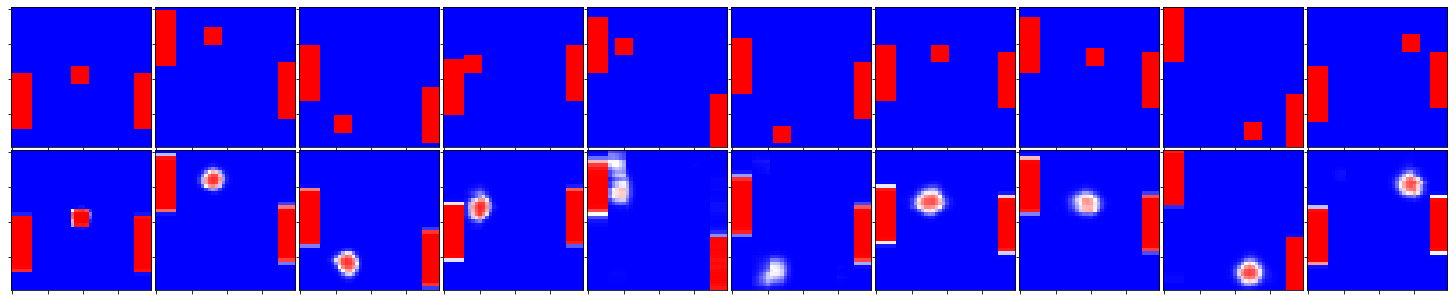

Epoch 75/2000
128/128 [==============================] - 49s 385ms/step - loss: 0.0415 - mse: 0.0122 - val_loss: 0.0325 - val_mse: 0.0097
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


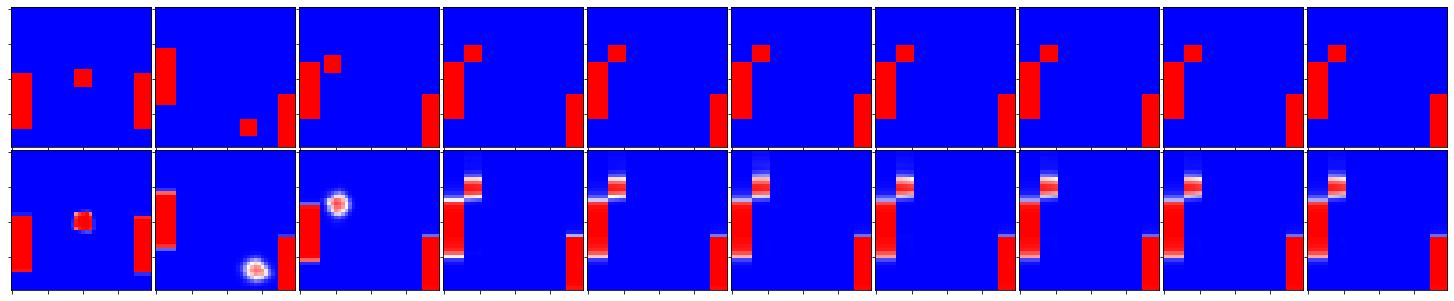

Epoch 76/2000
128/128 [==============================] - 49s 386ms/step - loss: 0.0343 - mse: 0.0102 - val_loss: 0.0305 - val_mse: 0.0092
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


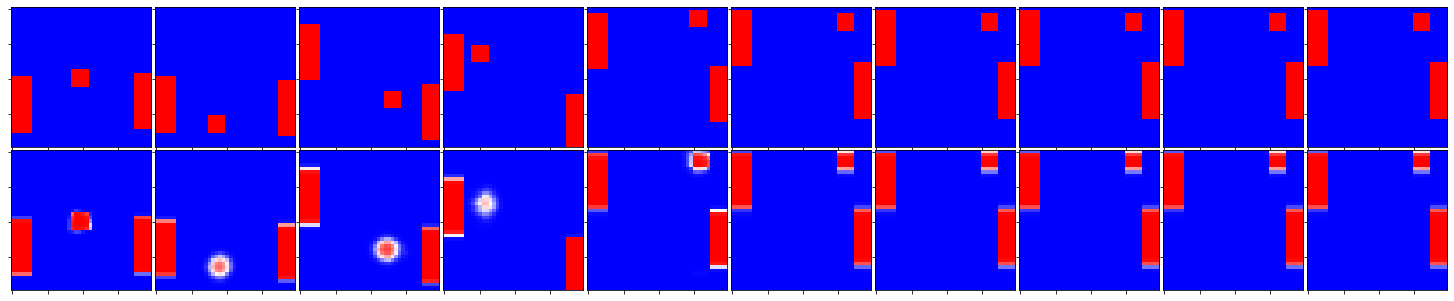

Epoch 77/2000
128/128 [==============================] - 51s 398ms/step - loss: 0.0319 - mse: 0.0095 - val_loss: 0.0337 - val_mse: 0.0099
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


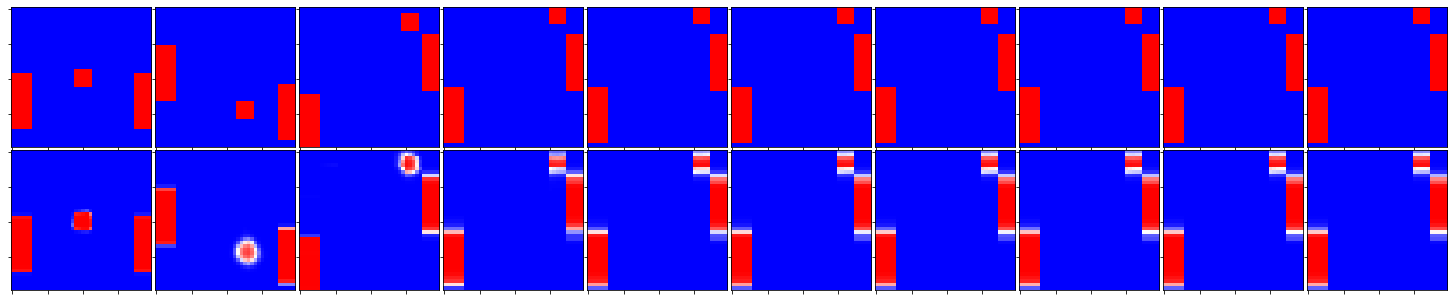

Epoch 78/2000
128/128 [==============================] - 52s 405ms/step - loss: 0.0327 - mse: 0.0098 - val_loss: 0.0288 - val_mse: 0.0086
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


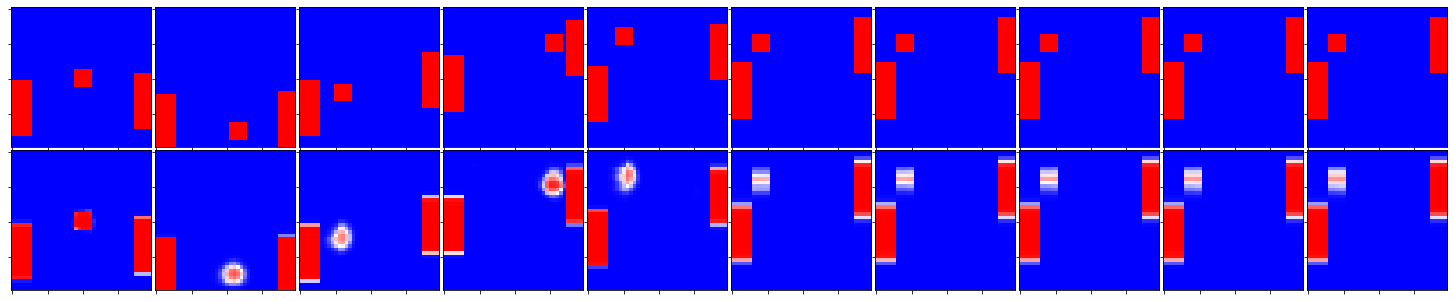

Epoch 79/2000
128/128 [==============================] - 51s 400ms/step - loss: 0.0294 - mse: 0.0088 - val_loss: 0.0368 - val_mse: 0.0108
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


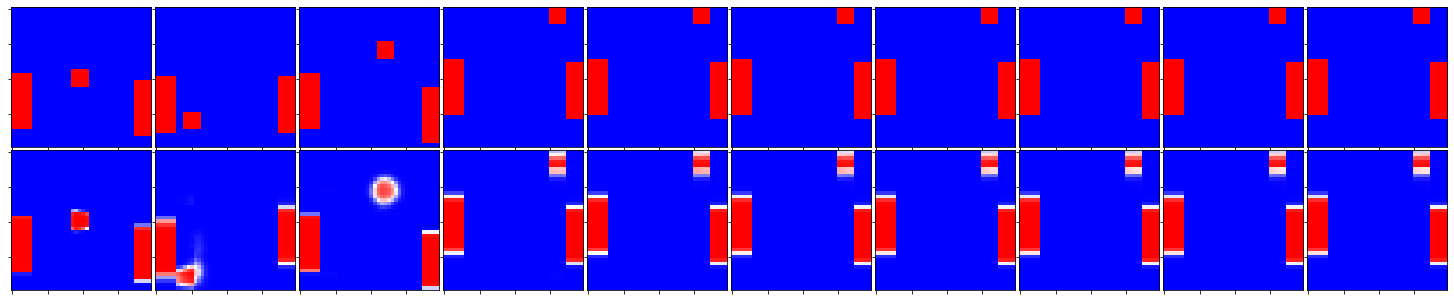

Epoch 80/2000
128/128 [==============================] - 51s 398ms/step - loss: 0.0335 - mse: 0.0100 - val_loss: 0.0375 - val_mse: 0.0114
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


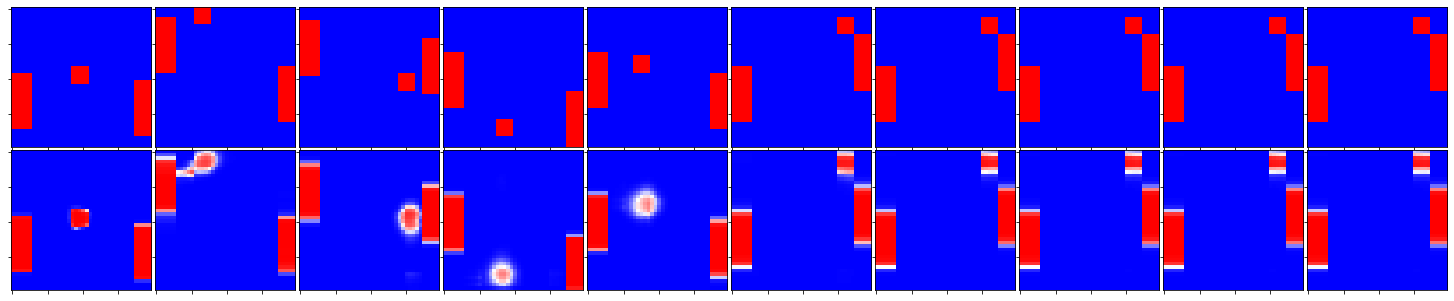

Epoch 81/2000
128/128 [==============================] - 50s 387ms/step - loss: 0.0353 - mse: 0.0105 - val_loss: 0.0375 - val_mse: 0.0111
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


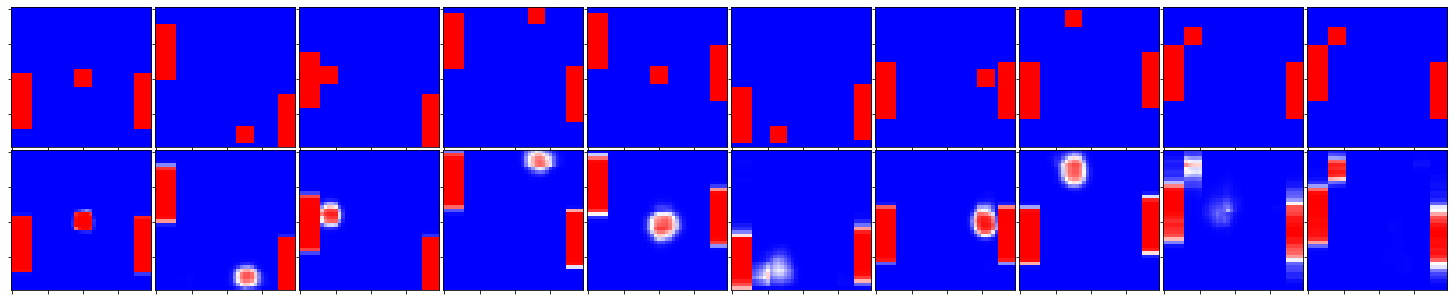

Epoch 82/2000
128/128 [==============================] - 50s 387ms/step - loss: 0.0363 - mse: 0.0108 - val_loss: 0.0329 - val_mse: 0.0096
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


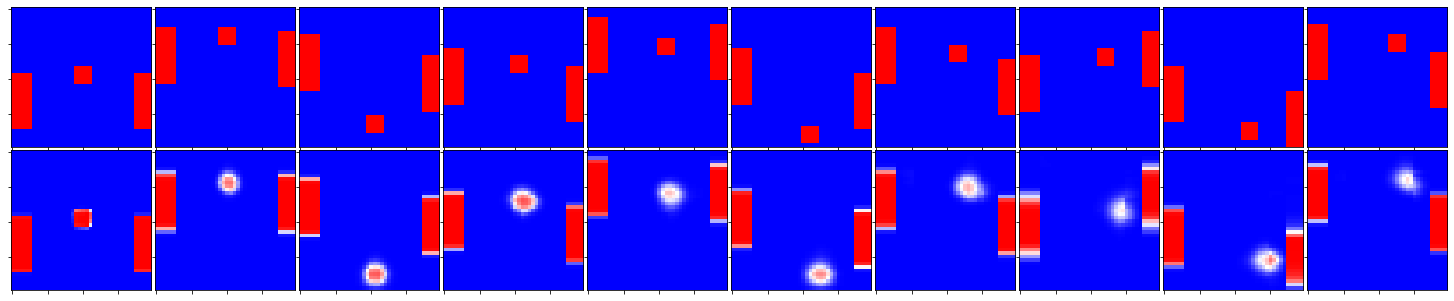

Epoch 83/2000
128/128 [==============================] - 51s 397ms/step - loss: 0.0303 - mse: 0.0090 - val_loss: 0.0355 - val_mse: 0.0104
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


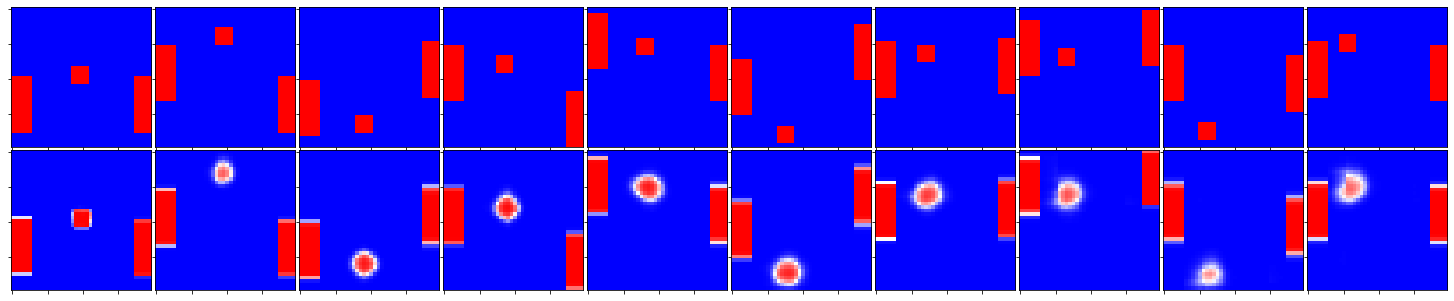

Epoch 84/2000
128/128 [==============================] - 50s 388ms/step - loss: 0.0332 - mse: 0.0099 - val_loss: 0.0300 - val_mse: 0.0092
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


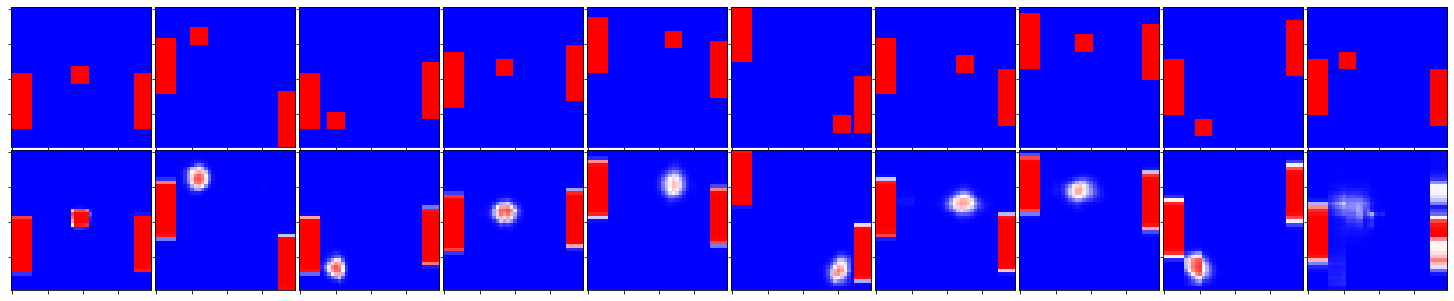

Epoch 85/2000
128/128 [==============================] - 49s 385ms/step - loss: 0.0264 - mse: 0.0079 - val_loss: 0.0260 - val_mse: 0.0078
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


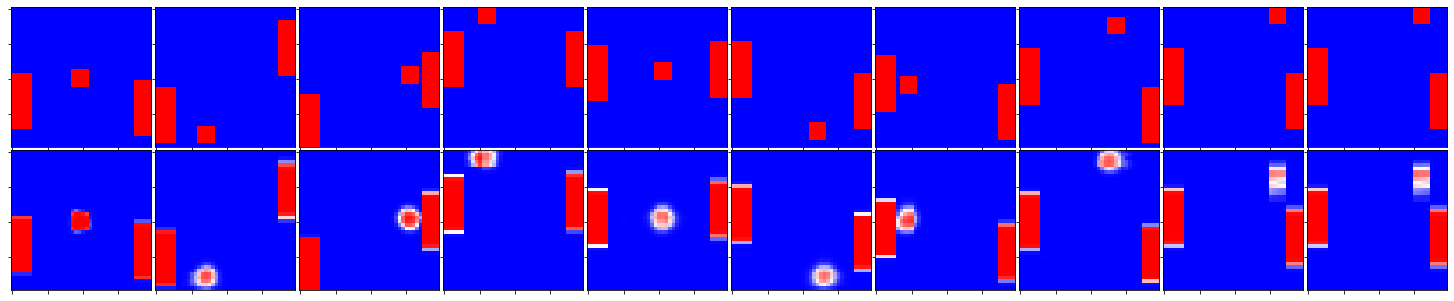

Epoch 86/2000
128/128 [==============================] - 49s 384ms/step - loss: 0.0320 - mse: 0.0094 - val_loss: 0.0381 - val_mse: 0.0114
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


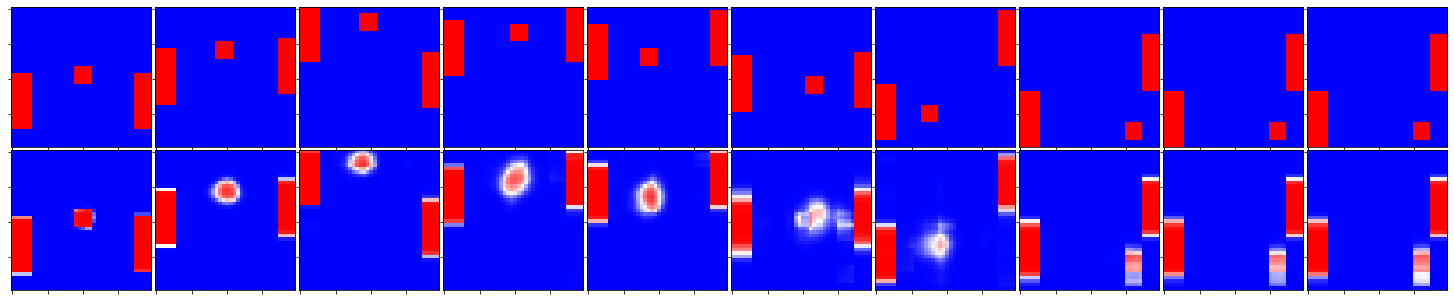

Epoch 87/2000
128/128 [==============================] - 49s 385ms/step - loss: 0.0299 - mse: 0.0089 - val_loss: 0.0264 - val_mse: 0.0080
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


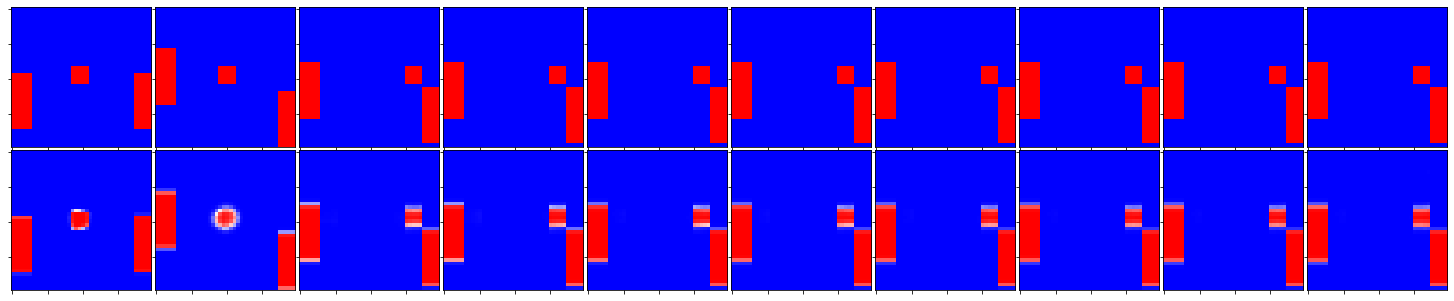

Epoch 88/2000
128/128 [==============================] - 49s 385ms/step - loss: 0.0236 - mse: 0.0070 - val_loss: 0.0211 - val_mse: 0.0063
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


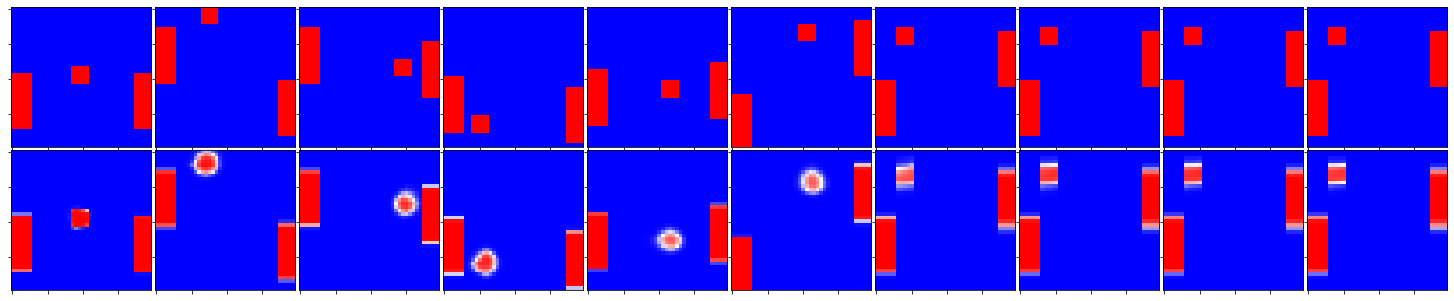

Epoch 89/2000
128/128 [==============================] - 49s 385ms/step - loss: 0.0297 - mse: 0.0088 - val_loss: 0.0395 - val_mse: 0.0120
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


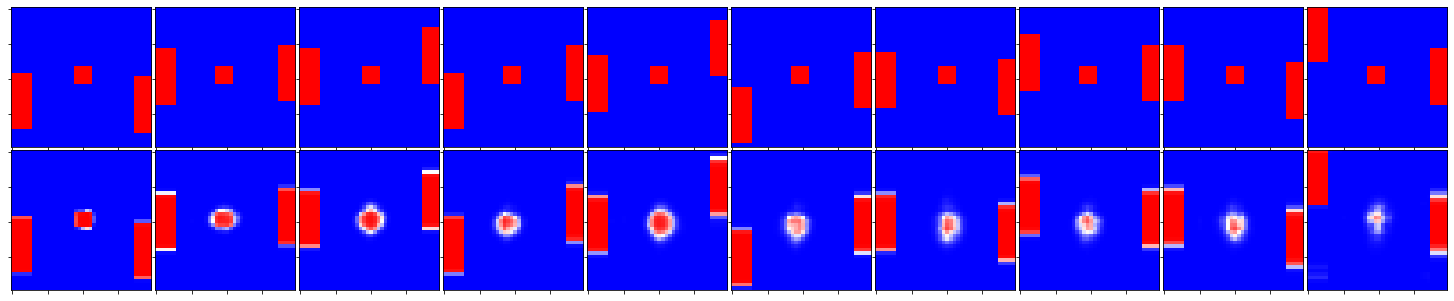

Epoch 90/2000
128/128 [==============================] - 49s 384ms/step - loss: 0.0347 - mse: 0.0102 - val_loss: 0.0289 - val_mse: 0.0087
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


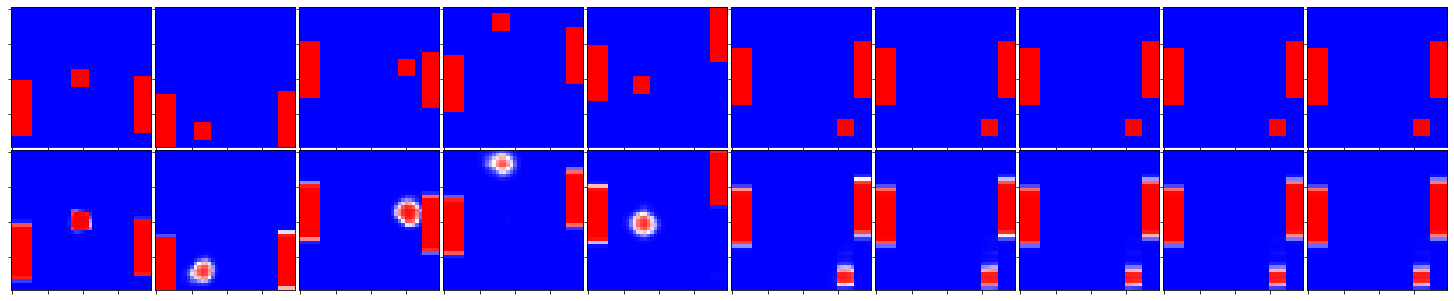

Epoch 91/2000
128/128 [==============================] - 49s 384ms/step - loss: 0.0268 - mse: 0.0080 - val_loss: 0.0323 - val_mse: 0.0097
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


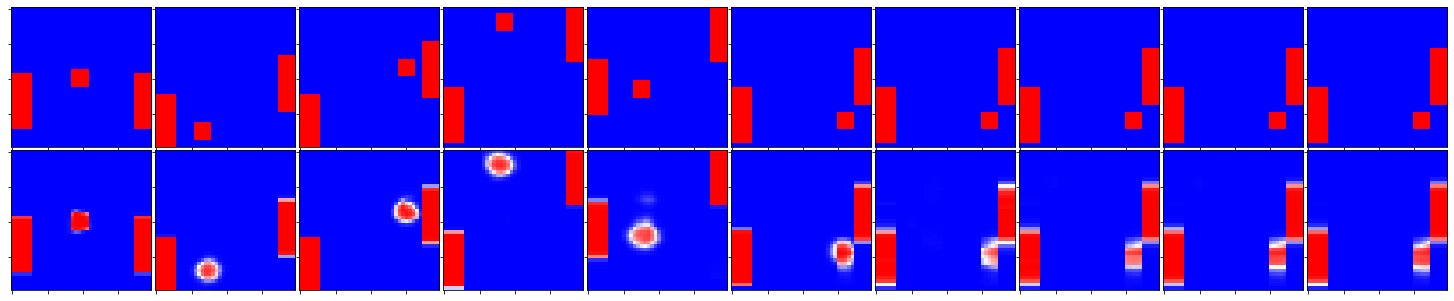

Epoch 92/2000
128/128 [==============================] - 49s 382ms/step - loss: 0.0352 - mse: 0.0104 - val_loss: 0.0339 - val_mse: 0.0102
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


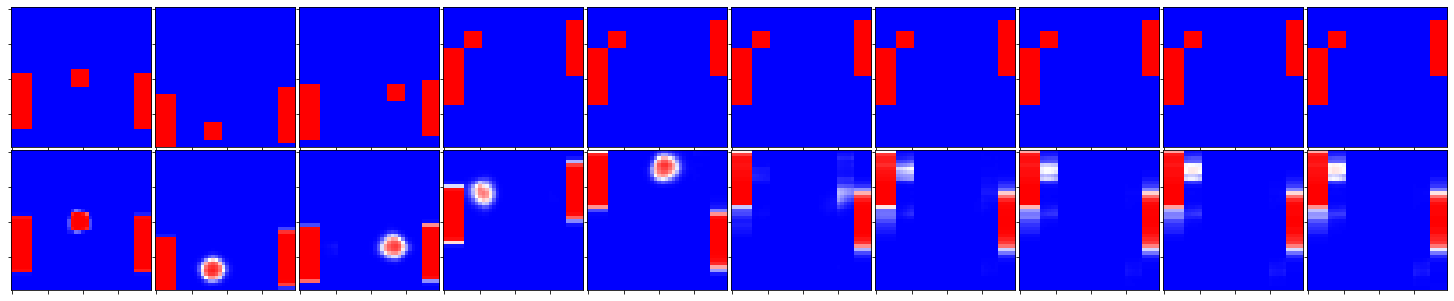

Epoch 93/2000
128/128 [==============================] - 49s 383ms/step - loss: 0.0253 - mse: 0.0075 - val_loss: 0.0238 - val_mse: 0.0072
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


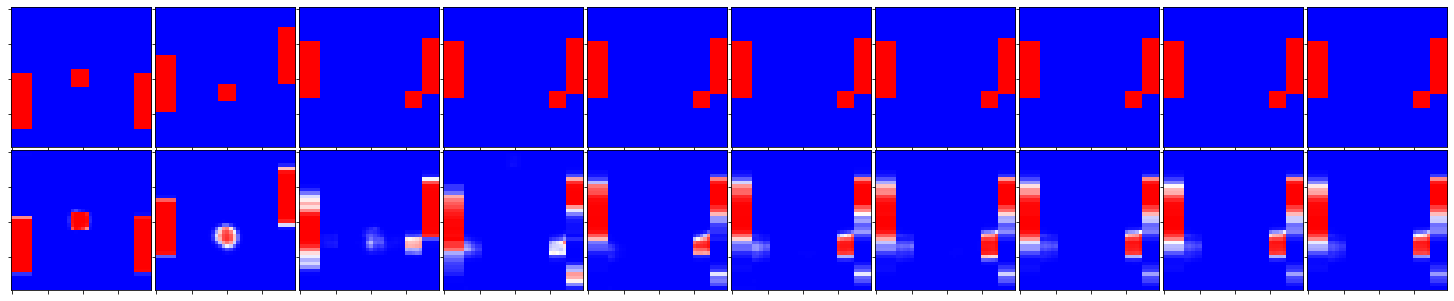

Epoch 94/2000
128/128 [==============================] - 49s 382ms/step - loss: 0.0249 - mse: 0.0074 - val_loss: 0.0516 - val_mse: 0.0148
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


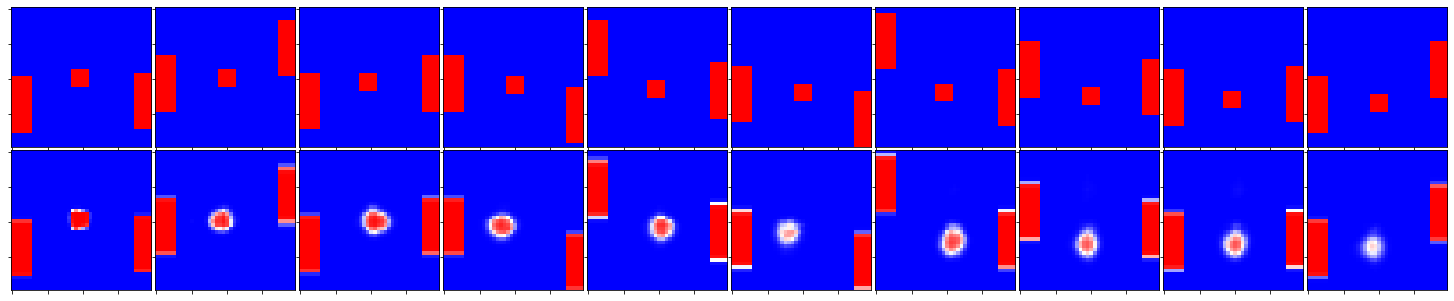

Epoch 95/2000
128/128 [==============================] - 49s 383ms/step - loss: 0.0333 - mse: 0.0099 - val_loss: 0.0275 - val_mse: 0.0083
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


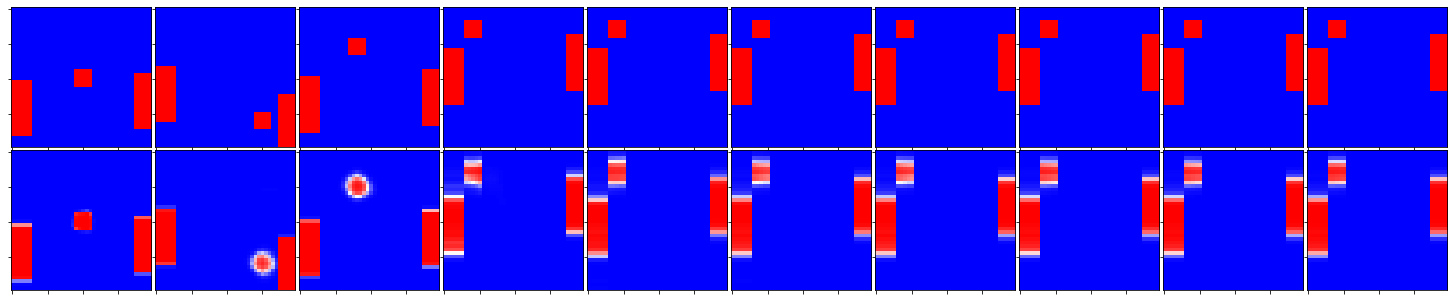

Epoch 96/2000
128/128 [==============================] - 50s 394ms/step - loss: 0.0237 - mse: 0.0071 - val_loss: 0.0252 - val_mse: 0.0075
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


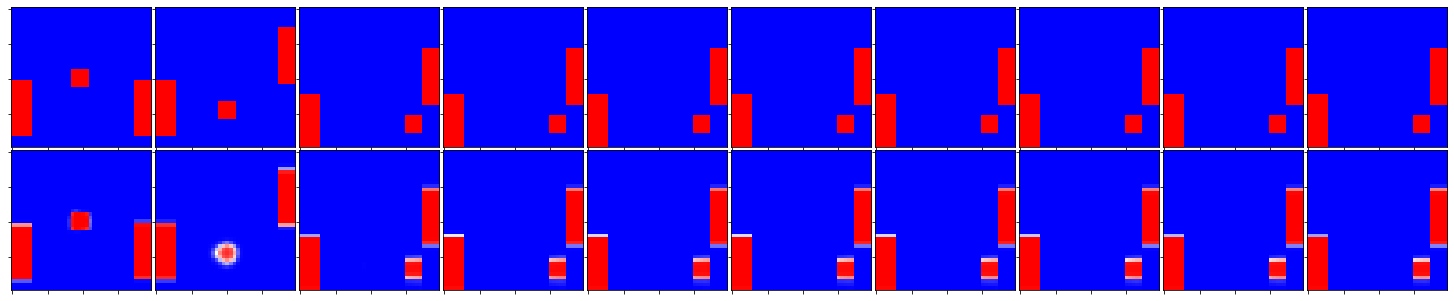

Epoch 97/2000
128/128 [==============================] - 50s 389ms/step - loss: 0.0223 - mse: 0.0067 - val_loss: 0.0257 - val_mse: 0.0077
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


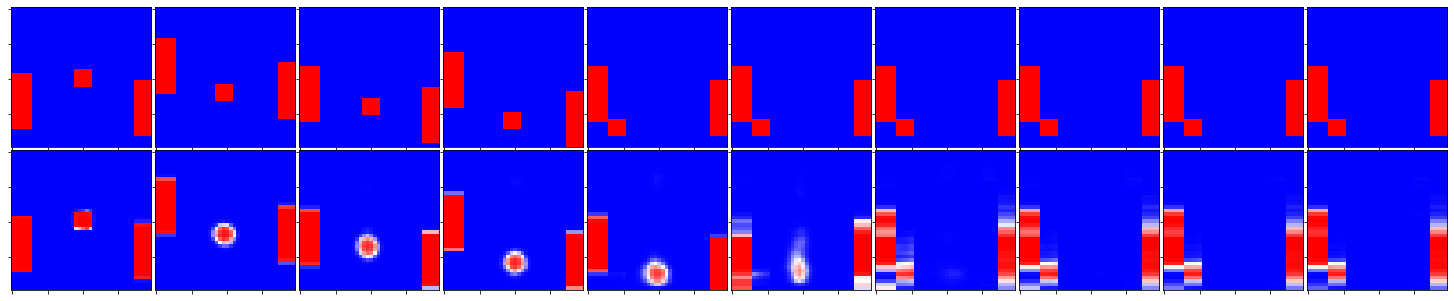

Epoch 98/2000
128/128 [==============================] - 50s 388ms/step - loss: 0.0374 - mse: 0.0109 - val_loss: 0.0355 - val_mse: 0.0108
Added image/png as content-type of artifact /home/izpc/workspace/differentiable-simulation/notebooks/pred_rollout.png.


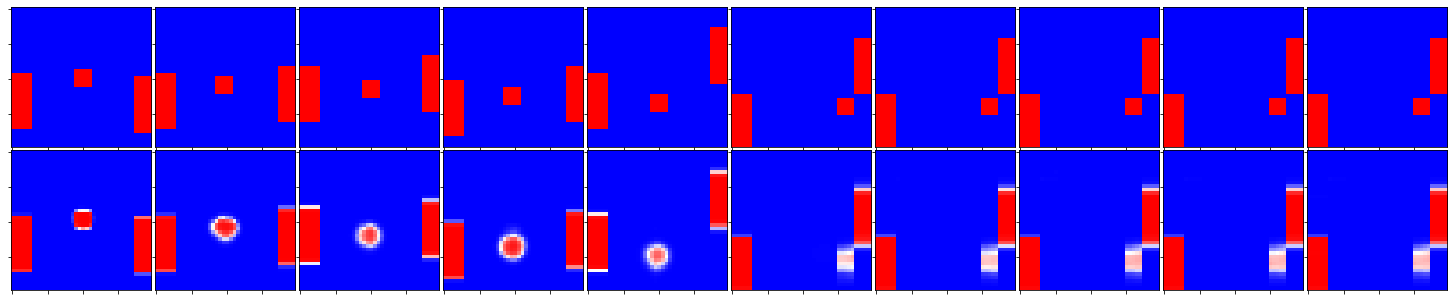

Epoch 99/2000
  2/128 [..............................] - ETA: 48s - loss: 0.0324 - mse: 0.0097

In [ ]:
ex.observers.append(sacred.observers.MongoObserver())
ex.run(config_updates={'should_preload_model': True})

In [ ]:
x = tf.random.uniform((5, 10, 10, 1))
x = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2))(x)
x = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2))(x)
x.shape